## 1 Импорт библиотек и модулей

In [1]:
!pip install -q ydata_profiling

In [2]:
%matplotlib inline

In [3]:
# библиотека для работы с данными
import pandas as pd

# для EDA анализа
import ydata_profiling

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека для работы с ошибками
import warnings

# библиотека для математических вычислений
import numpy as np

# модуль для проверки гипотез
from scipy import stats as st

## 2 Открытие файла с данными и изучение общей информации
Считаем данные из csv-файла в датафрейм, сохраним в переменную `df` и проведём EDA анализ.

In [4]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv')
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv')
    ydata_profiling.ProfileReport(df, progress_bar=False, correlations={"auto": {"calculate": False}})\
    .to_file(name + '.html')
    return df

In [5]:
df = read_eda('games')

[Посмотреть анализ.](https://www.dropbox.com/s/w12tlh3wp10jdsw/games.html?dl=0)

- **В данных 16715 строк, 11 столбцов, 2 типа данных: float64, object.** 
- **Обнаружены некорректные названия и типы столбцов.**
- **Присутствуют пропуски.**

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>После изучения данных, стала ясна их общая структура:</b> 16715 строк, 11 столбцов, 2 типа данных: float64, object.<br> <b>Также были обнаружены данные, подлежащие обработке:</b>
        <li>Названия и типы столбцов.</li>
        <li>Пропуски.</li>
    </p>  
</div>

## 3 Предобработка данных
### 3.1 Переименование столбцов
Приведём все столбцы к нижнему регистру.

In [6]:
df.columns = df.columns.str.lower()

Проверим названия столбов.

In [7]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### 3.2 Обработка пропусков и изменение типов данных
**Определим, в каких столбцах есть пропуски.**

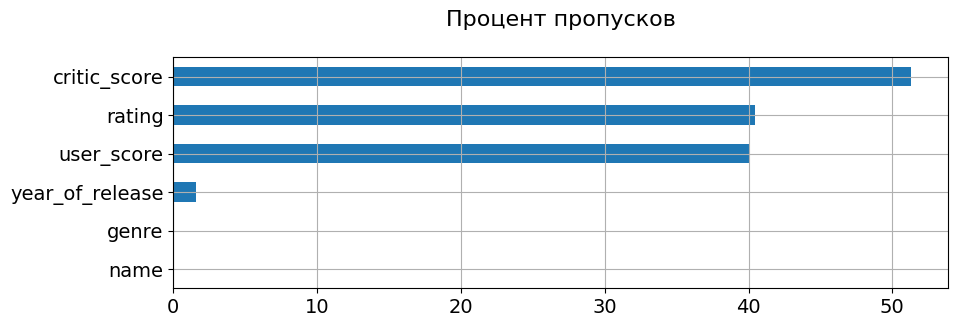

In [8]:
try:
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by='space', ascending=True)
        .plot(kind='barh', figsize=(10, 3), legend=False, fontsize=14, grid=True)
        .set_title('Процент пропусков' + "\n", fontsize=16)    
    );    
except:
    print('Пропусков нет.')

#### Столбцы `name` и `genre`
Выведем строки с пропусками.

In [9]:
df[(df['name'].isna()) | (df['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


**Скорее всего причиной пропусков стали технические ошибки, так как пропуски находятся в одинаковых столбцах, и платформы с годами идентичны.**

С учётом того, что ключевые поля не заполнены, пропуски невозможно заменить, поэтому удалим их, предварительно создав копию старого датафрейма.

In [10]:
old_df = df.copy()
df = df.dropna(subset=['genre', 'name'])

#### Столбец `year_of_release`
**Мне кажется, пропуски здесь тоже обусловлены техническими ошибками.**

Выведем первые 5 строк с пропусками.

In [11]:
df[df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Можно заметить, что в некоторых названиях игр есть годы, выведем подобные строки.

In [12]:
indexes = []
years = []

for index in df[df['year_of_release'].isna()].index:
    name = df['name'][index].split()[-1]
    if name.isdigit():
        if pd.to_numeric(name) in df['year_of_release'].unique():
            indexes.append(index)
            years.append(int(name))
            
df.loc[indexes, :]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
1650,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E
3486,Madden NFL 2002,XB,NaN,Sports,0.53,0.02,0.00,0.03,90.0,8.1,E
4775,NFL GameDay 2003,PS2,NaN,Sports,0.20,0.15,0.00,0.05,60.0,tbd,E
5156,NBA Live 2003,XB,NaN,Sports,0.31,0.04,0.00,0.01,82.0,8.8,E
5655,All-Star Baseball 2005,PS2,NaN,Sports,0.16,0.12,0.00,0.04,72.0,8.6,E
5889,NBA Live 2003,GC,NaN,Sports,0.23,0.06,0.00,0.01,82.0,8.2,E
8918,All-Star Baseball 2005,XB,NaN,Sports,0.11,0.03,0.00,0.01,75.0,8.8,E


**Большая часть игр с годом в названии — спортивные. Обычно год их выпуска на единицу меньше года в названии (это можно хорошо проследить по серии игр [FIFA](https://ru.wikipedia.org/wiki/FIFA_(%D1%81%D0%B5%D1%80%D0%B8%D1%8F_%D0%B8%D0%B3%D1%80))), так и заменим пропуски в этих строках.**

In [13]:
df.loc[indexes, 'year_of_release'] = [year - 1 for year in years]

Выведем кол-во оставшихся пропусков.

In [14]:
df['year_of_release'].isna().sum()

254

Посмотрим, какое максимальное число продаж принесли оставшиеся игры.

In [15]:
df.loc[df['year_of_release'].isna(), 'na_sales':'other_sales'].max()

na_sales       2.36
eu_sales       0.97
jp_sales       0.77
other_sales    0.35
dtype: float64

Их продажи небольшие, пропуски там заменить сложно и их мало, поэтому можем удалить.

In [16]:
df = df.dropna(subset=['year_of_release'])

Годы не могут быть вещественными, поэтому преобразуем столбец в целочисленный формат.

In [17]:
df['year_of_release'] = df['year_of_release'].astype(int)

#### Столбец `critic_score`

Построим график с динамикой количества игр и пропусков в оценках критиков, чтобы выяснить возможные причины их появления.

In [18]:
years_df = df.pivot_table(index='year_of_release', values='name', aggfunc='count')
for year in years_df.index:
    years_df.loc[year, 'nan'] = df.query('year_of_release == ' + str(year))['critic_score'].isna().sum()

In [19]:
def dynamics_subplots(title, df=years_df, column_1='name', column_2='nan', label_1='Игры', label_2='Пропуски'):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df[column_1], label=label_1)
    ax.plot(df[column_2], label=label_2)
    ax.legend(loc='upper left', prop={'size': 12}) 
    ax.grid()
    
    plt.title(title + "\n", size=15)
    plt.xlabel('Годы', size=13)
    plt.ylabel('Количество', size=13)
    plt.show()

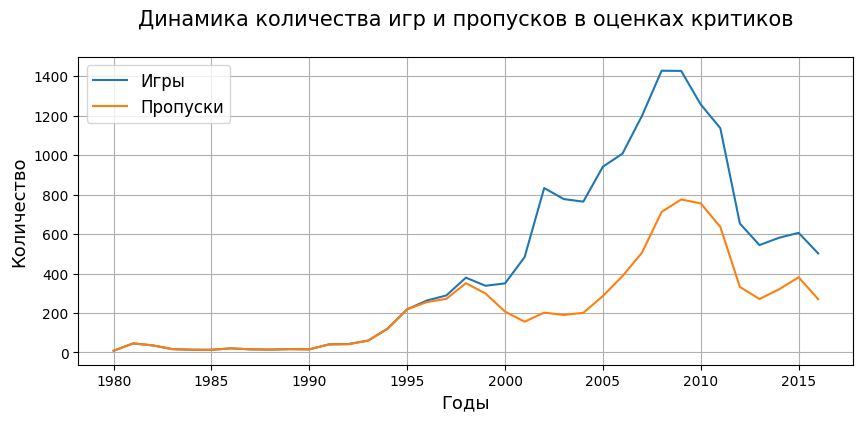

In [20]:
dynamics_subplots(title='Динамика количества игр и пропусков в оценках критиков')

- **Примерно до 1995 года выпускалось довольно мало игр ([индустрия только начинала набирать популярность](https://stepgames.ru/blog/istoriya-kompyuternyh-igr)), скорее всего поэтому и не было оценок.**
- **С 2000 года кол-во игр начало стремительно расти, и, возможно, критиков стало не хватать для таких объёмов.**

Пропуски в этом столбце оставим, заменить их сложно, так как оценки критиков зависят от многих параметров.

#### Столбец `user_score`

Построим график с динамикой количества игр и пропусков в оценках пользователей, чтобы выяснить возможные причины их появления.

In [21]:
for year in years_df.index:
    years_df.loc[year, 'nan'] = df.query('year_of_release == ' + str(year))['user_score'].isna().sum()

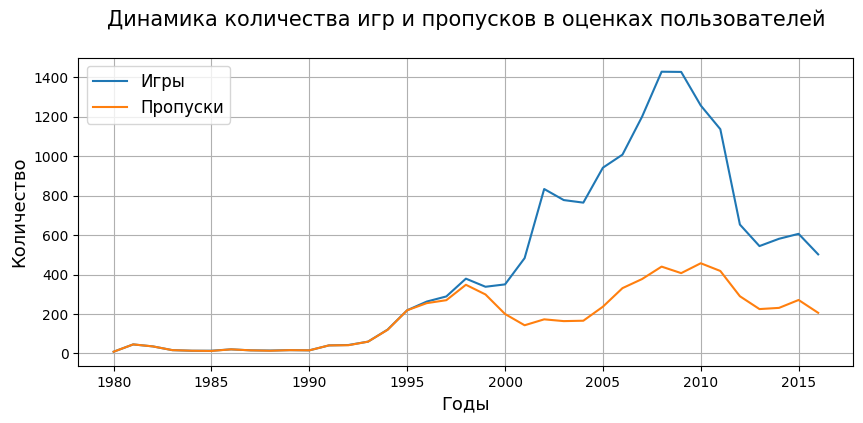

In [22]:
dynamics_subplots(title='Динамика количества игр и пропусков в оценках пользователей')

- **Ситуация с оценками пользователей до 1995 года схожа с оценками критиков тех же годов. Пропусков много, так как в те времена мало у кого был доступ в интернет, оценки было бы сложно получить.**
- **Также нельзя отрицать наличие технических ошибок, построим сравнительный график по пропускам в `user_score` и `rating`.**
<a id='errors'></a>

In [23]:
years = sorted(list(df['year_of_release'].unique()))
errors_df = pd.DataFrame(index=years)

for year in years:
    errors_df.loc[year, 'user_nan'] = df.query('year_of_release == ' + str(year))['user_score'].isna().sum()
    errors_df.loc[year, 'rating_nan'] = df.query('year_of_release == ' + str(year))['rating'].isna().sum()

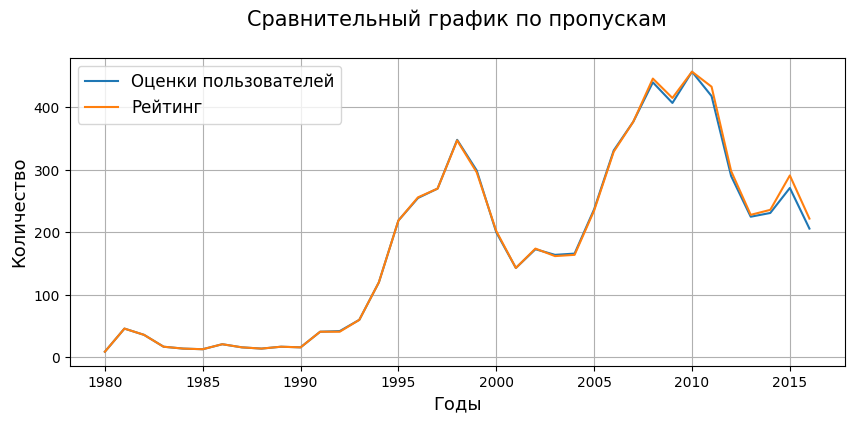

In [24]:
dynamics_subplots(title='Сравнительный график по пропускам', df=errors_df, column_1='user_nan', 
                  column_2='rating_nan', label_1='Оценки пользователей', label_2='Рейтинг')

**Значения практически совпадают, похоже, что пропуски и правда могли быть вызваны техническими ошибками при записи.**

Помимо пропусков столбец `user_score` содержит аббревиатуру `tbd` (to be determined — будет определено), для удобства заменим её на NaN и изменим формат столбца на вещественный, чтобы появилась возможность проведения операций над числами.

In [25]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan
df['user_score'] = df['user_score'].astype(float)

Пропуски в этом столбце оставим, заменить их сложно, так как оценки пользователей также зависят от многих параметров.

#### Столбец `rating`

Построим график с динамикой количества игр и пропусков в рейтингах, чтобы выяснить возможные причины их появления.

In [26]:
for year in years_df.index:
    years_df.loc[year, 'nan'] = df.query('year_of_release == ' + str(year))['rating'].isna().sum()

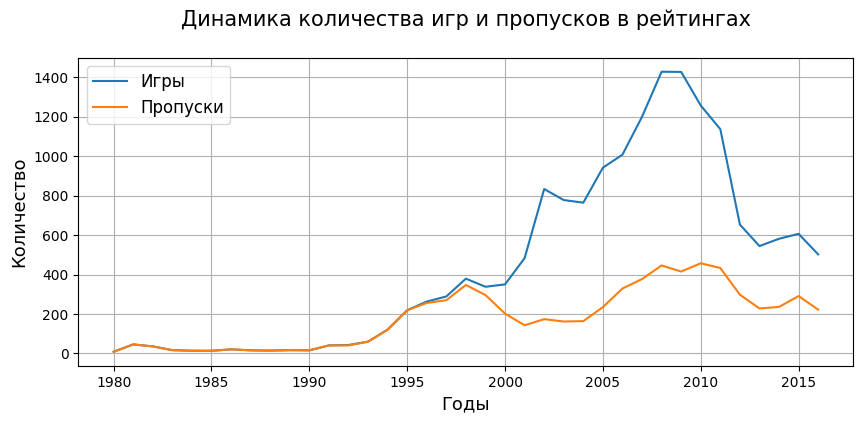

In [27]:
dynamics_subplots(title='Динамика количества игр и пропусков в рейтингах')

- **Примерно до 1995 года рейтингов не было, это можно объяснить датой основания [ESRB](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board).**
- **Последующие пропуски можно объяснить [техническими ошибками](#errors).**

Посмотрим, повторяются ли игры в данных.

In [28]:
print('В данных ' + str(df.shape[0] - df['name'].nunique()) + ' неуникальных игр.')

В данных 5027 неуникальных игр.


Игры с одним названием не могут иметь разные рейтинги от одной организации, поэтому заменим пропуски в их рейтингах модой на других платформах.

In [29]:
warnings.filterwarnings("ignore")
df['rating'] = df['rating'].fillna(df.groupby('name')['rating'].transform(lambda x:x.mode(dropna=False)[0]))

Проверим наличие пропусков.

In [30]:
df['rating'].isna().sum()

6413

Остальные пропуски заменим на `unknown` для удобства в дальнейшем анализе.

In [31]:
df['rating'] = df['rating'].fillna('unknown')

### 3.3 Добавление столбцов
Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [32]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis='columns') 

### 3.4 Обработка дубликатов

**Посмотрим наличие явных дубликатов в данных.**

In [33]:
df.duplicated().sum()

0

**Явных дубликатов нет, проверим наличие неявных для пары "Имя - Игровая консоль".**

In [34]:
df[df.duplicated(subset=['name', 'platform'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E,2.56
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T,1.56
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T,1.25
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T,0.29
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T,0.08
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E,0.01


- **"Need for Speed: Most Wanted" — одинаковое название двух игр, вышедших в разные годы ([серия игр Need for Speed](https://ru.wikipedia.org/wiki/Need_for_Speed_(%D1%81%D0%B5%D1%80%D0%B8%D1%8F_%D0%B8%D0%B3%D1%80))), поэтому их оставляем.**
- **С "Madden NFL 13", думаю, произошла перезапись данных, поэтому оставим строку с большими продажами.**

In [35]:
df = df.drop(labels=[16230], axis=0)

### 3.5 Общий ущерб

In [36]:
print(f'Всего удалено {old_df.shape[0] - df.shape[0]} значений.')

Всего удалено 257 значений.


<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты обработки данных:</b>
        <ol>
        <li>Переименованы столбцы.</li>
        <li>Изменены типы данных.</li>
        <li>Обработаны пропуски.</li>
        <li>Добавлены новый столбец с сумарными продажами во всех регионах.</li>
        <li>Обработаны дубликаты.</li>
        </ol>
        <b>В общем удалено 257 значений.</b>
   </p>  
</div>

## 4 Исследовательский анализ данных
### 4.1 Определение актуального периода
Посмотрим, как менялись продажи по платформам.

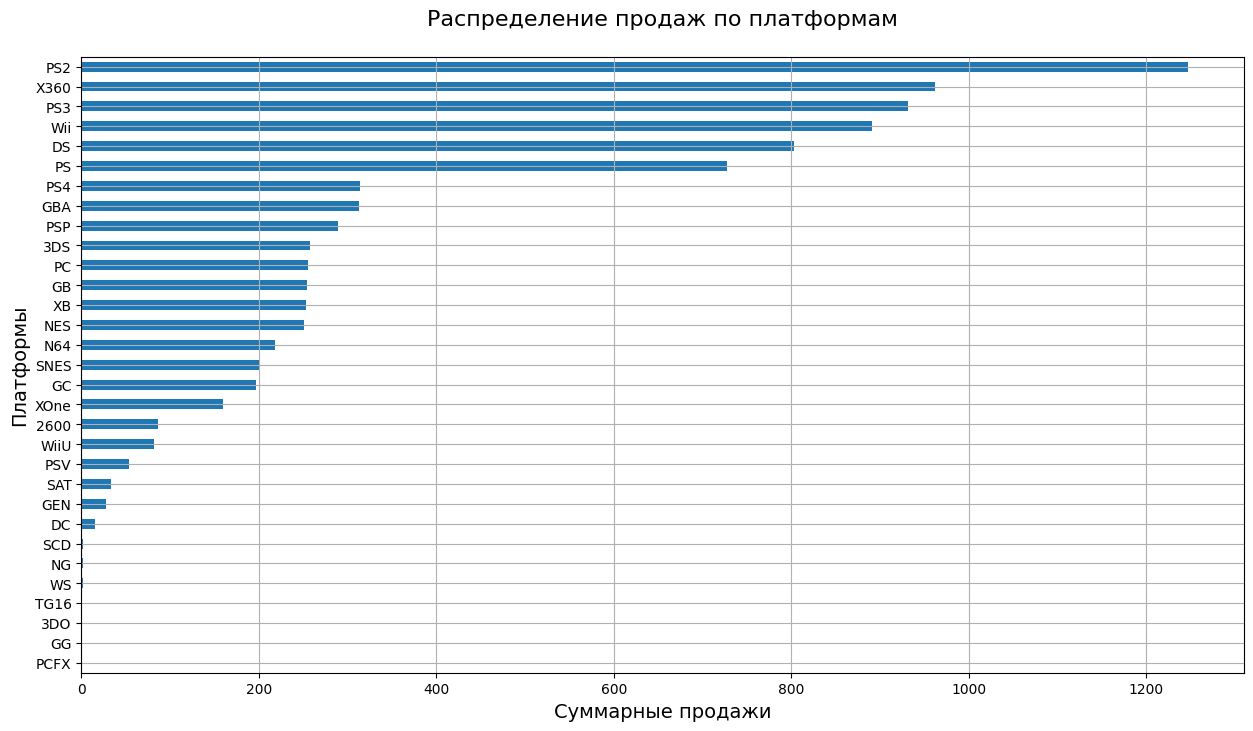

In [37]:
def categorical_distribution(df=df, index='platform', values='total', 
                             figsize=5, country=' ', title='платформам', ylabel='Платформы'):
    df = df.groupby(index)[values + '_sales'].sum().sort_values()
    df.plot(grid=True, figsize=(15, figsize), legend=False, kind='barh')
    plt.title('Распределение продаж' + country +  'по ' + title + "\n", size=16)
    plt.xlabel('Суммарные продажи', size=14)
    plt.ylabel(ylabel, size=14)
    plt.show()
    return df

platform_distribution = categorical_distribution(figsize=8)

**Самые популярные платформы — PS2, X360, PS3, Wii, DS и PS.**

Построим распределение их продаж по годам.

In [38]:
def years_distribution(df=df):
    (
        df
        .query('platform == @platform')
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .plot(grid=True, figsize=(15, 4), legend=False, style='-o')
    )
    plt.title('Распределение продаж игр для ' + platform + ' по годам' + "\n", size=16)
    plt.xlabel('Годы', size=14)
    plt.ylabel('Суммарные продажи', size=14)
    plt.show()

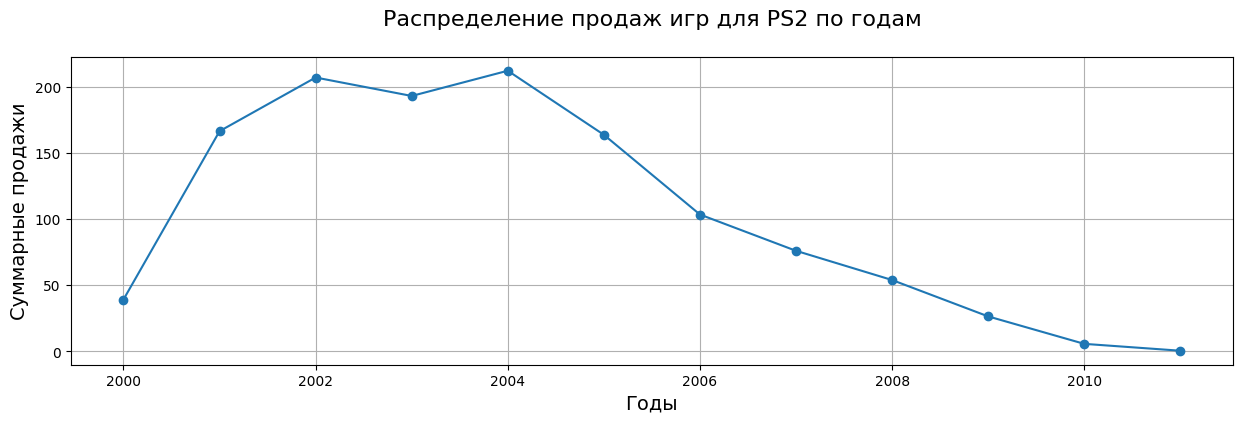

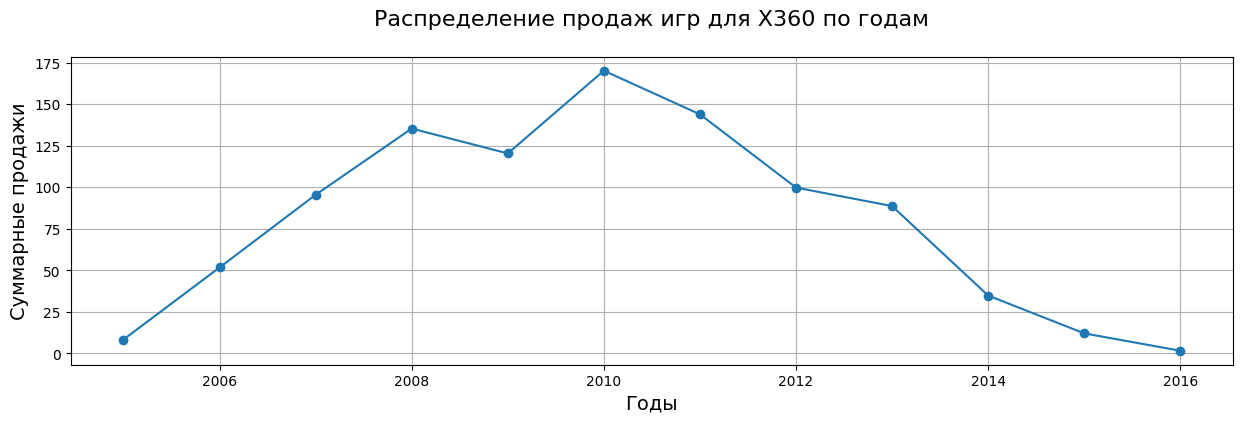

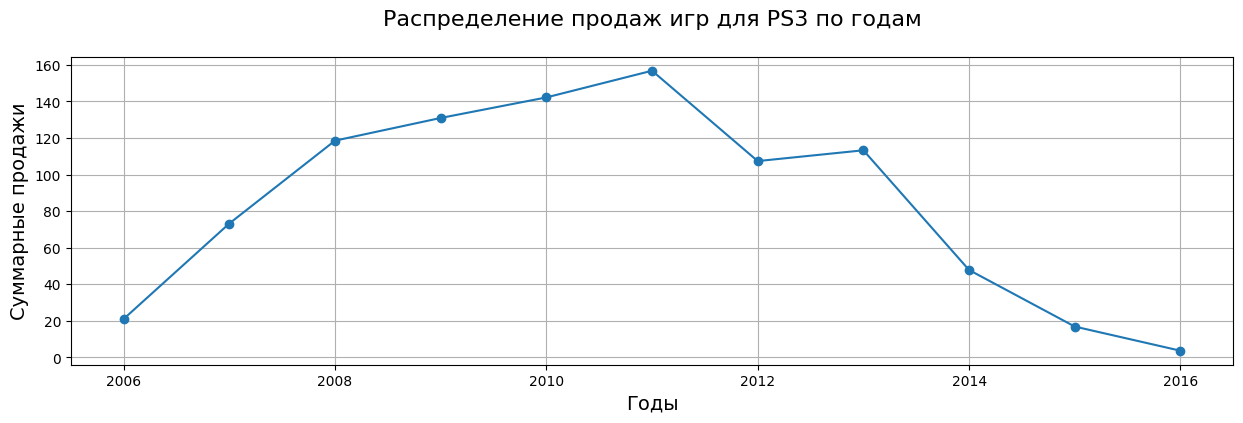

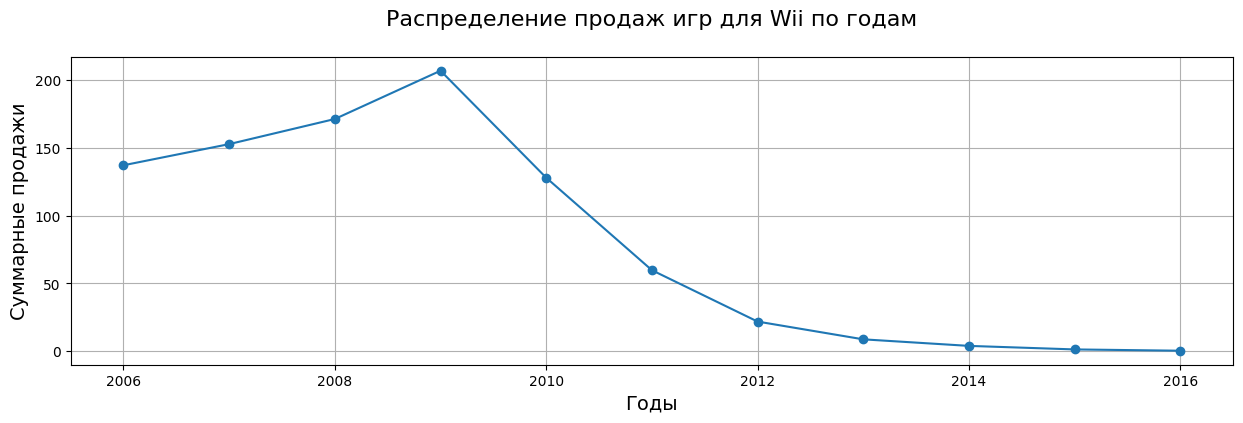

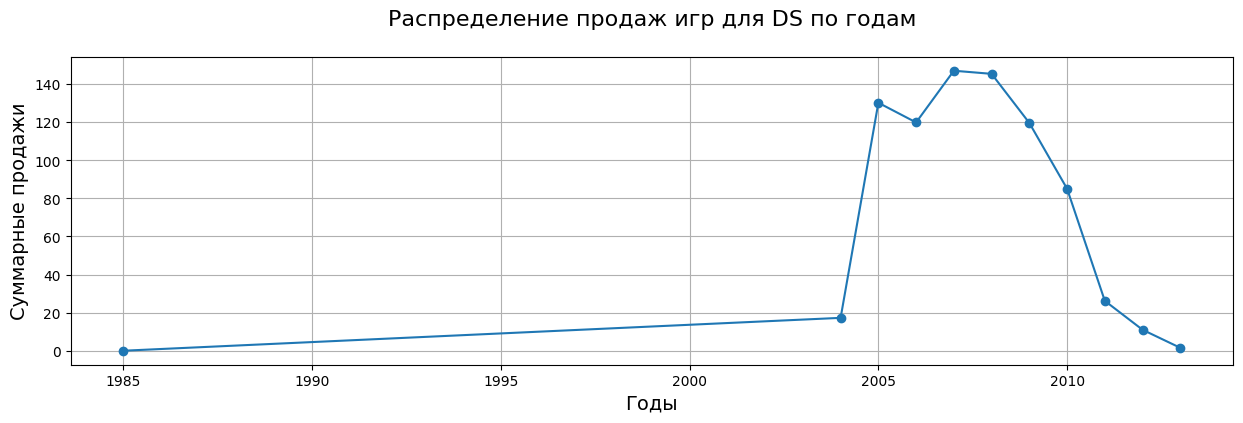

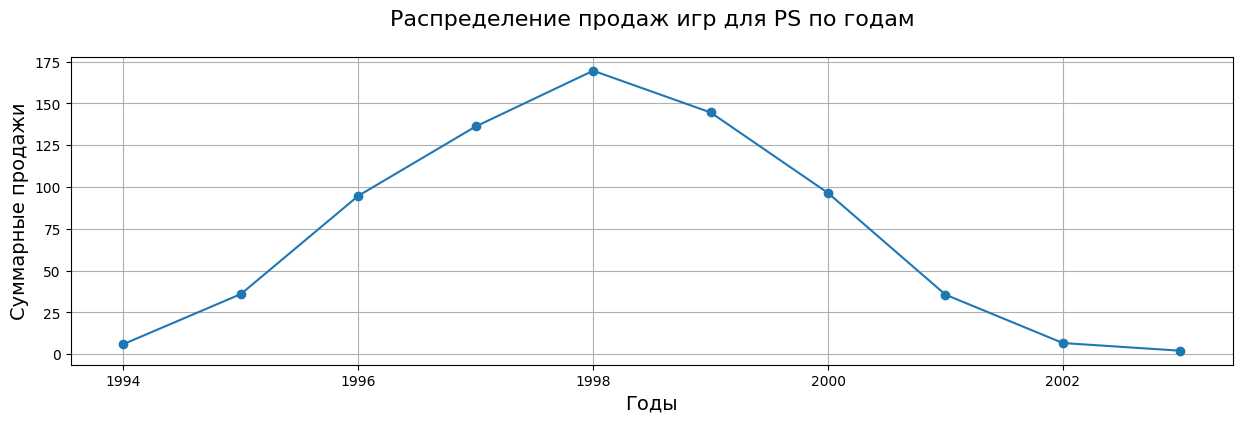

In [39]:
for platform in platform_distribution.index[-6:][::-1]:
    years_distribution()

**Примерный срок, за который появляются новые и исчезают старые платформы — 10 лет.**

Посмотрим, сколько игр выпускалось в разные годы.

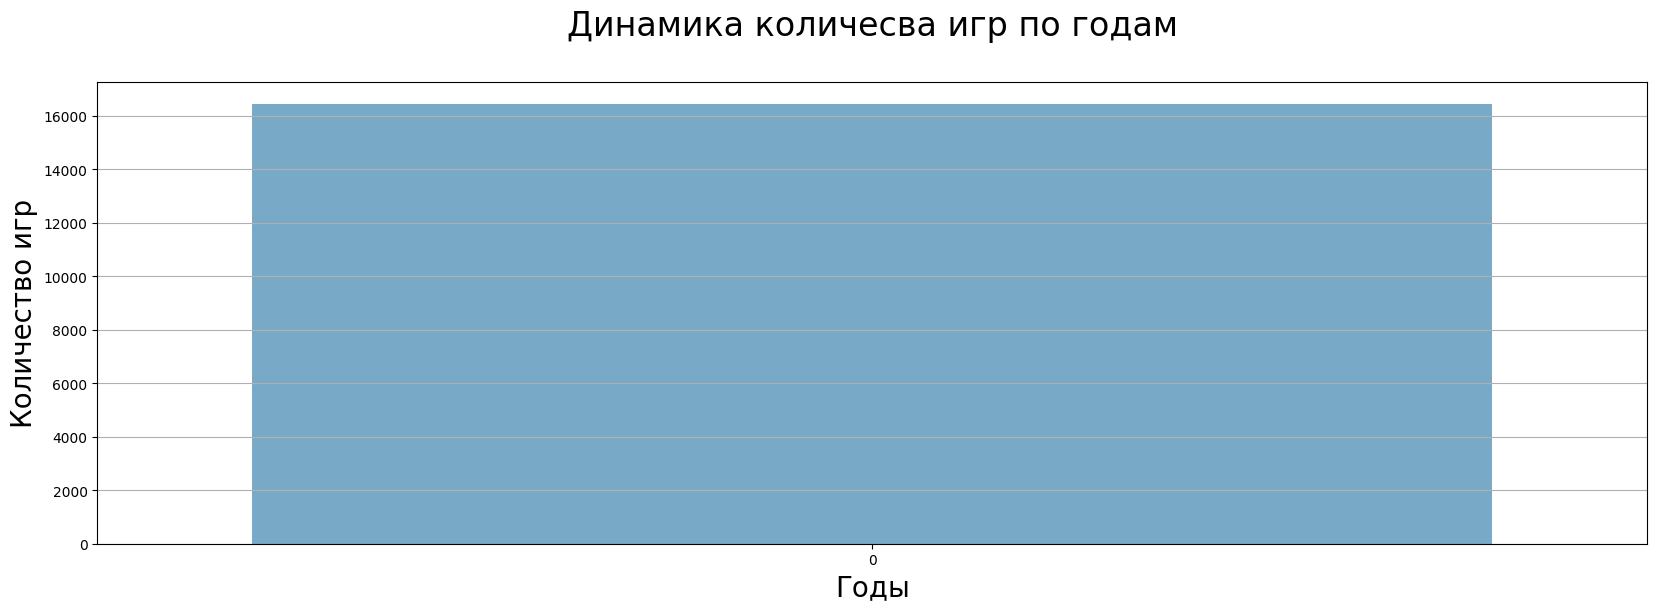

In [40]:
plt.figure(figsize=(20, 6))
plt.grid()
sns.countplot(df['year_of_release'], palette="Blues")
plt.title('Динамика количесва игр по годам' + "\n", size=24)
plt.xlabel('Годы', size=20)
plt.ylabel('Количество игр', size=20)
plt.show()

- **Игр до 2001 довольно мало, опять же, в те времена только зарождалась культура, поэтому этот период не важен для будущего прогнозирования.**
- **До 2012 года выпускалось много игр, индустрия хорошо развивалась, эти годы тоже не будем учитывать.**
- **С 2012 по 2016 год количество игр сильно снизилось из-за возросших требований игроков, в дальнейшем будем работать с этим периодом.**

Уберём неактуальный период из данных.

In [41]:
actual_df = df.query('year_of_release >= 2012')

### 4.2 Выявление потенциально прибыльных платформ
Посмотрим, какие платформы лидируют по продажам за актуальный период.

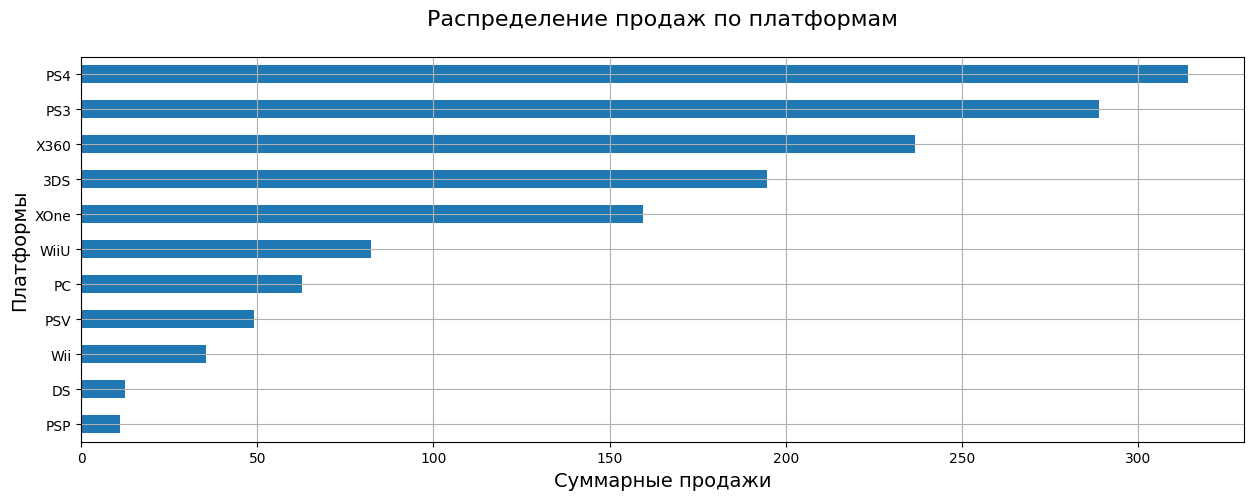

In [42]:
platform_distribution = categorical_distribution(df=actual_df)

**Лидирующие по продажам платформы — PS4, PS3, X360, 3DS и XOne.**

Посмотрим динамику продаж игр для платформ за актуальный период.

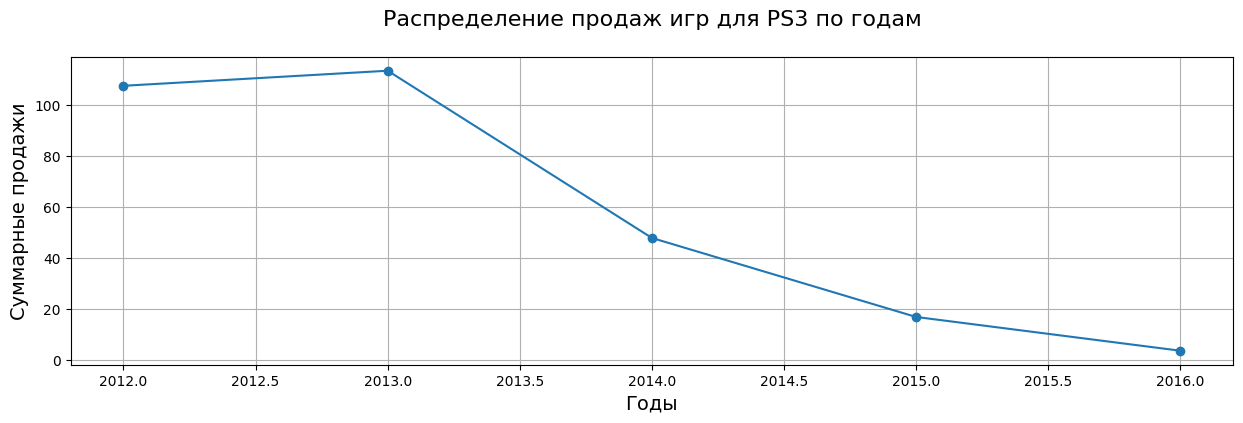

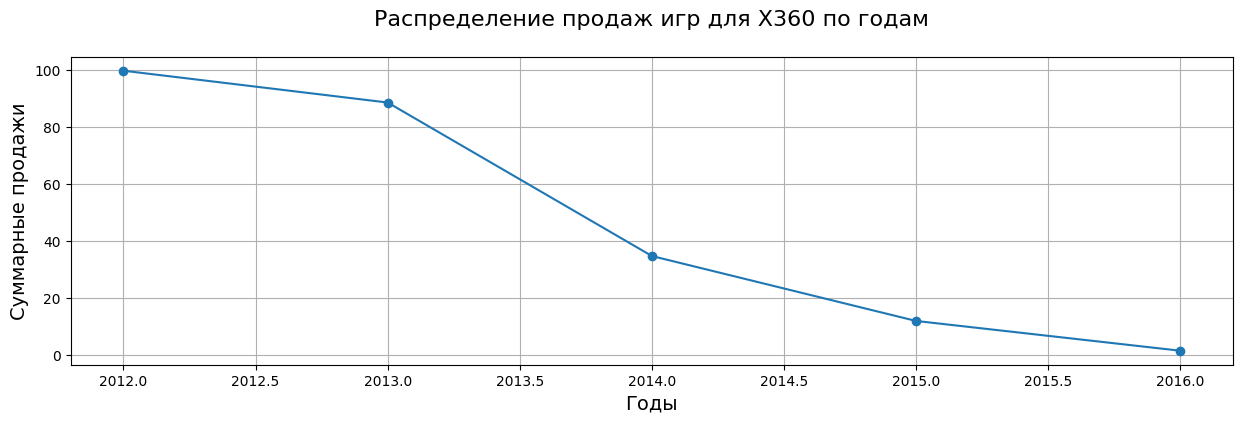

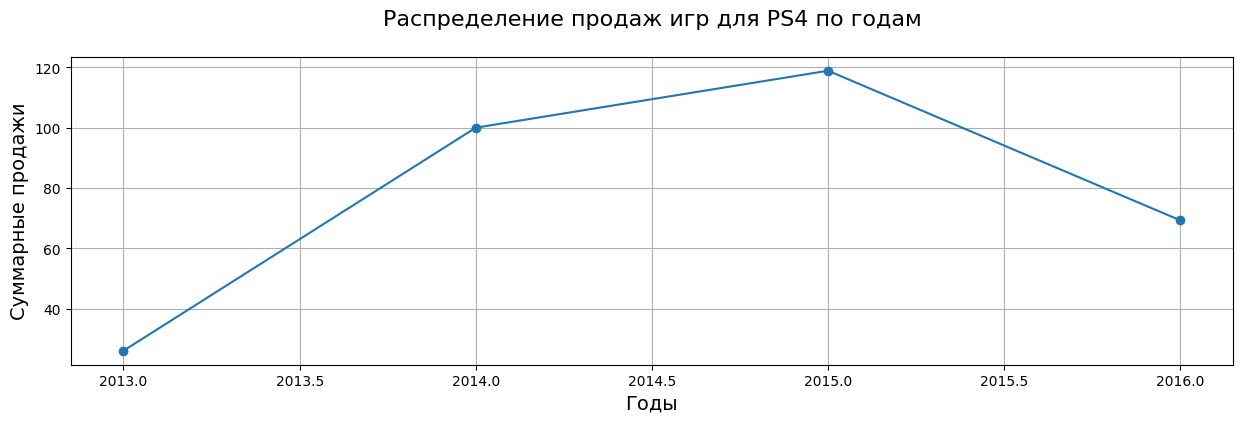

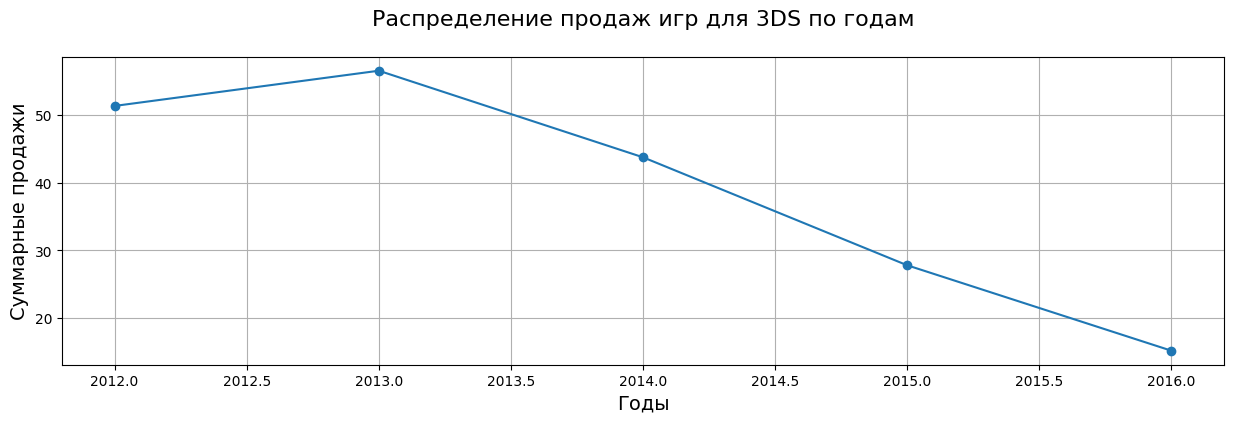

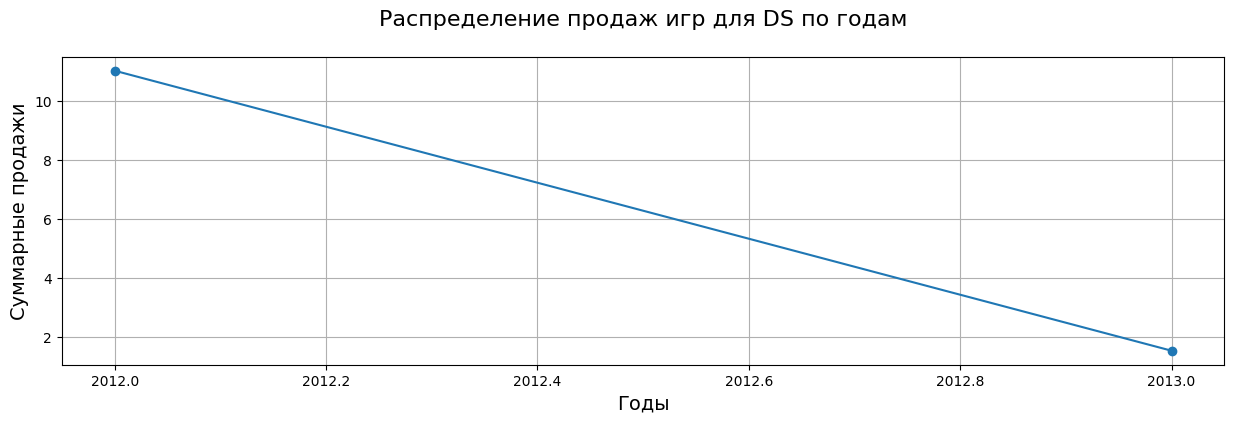

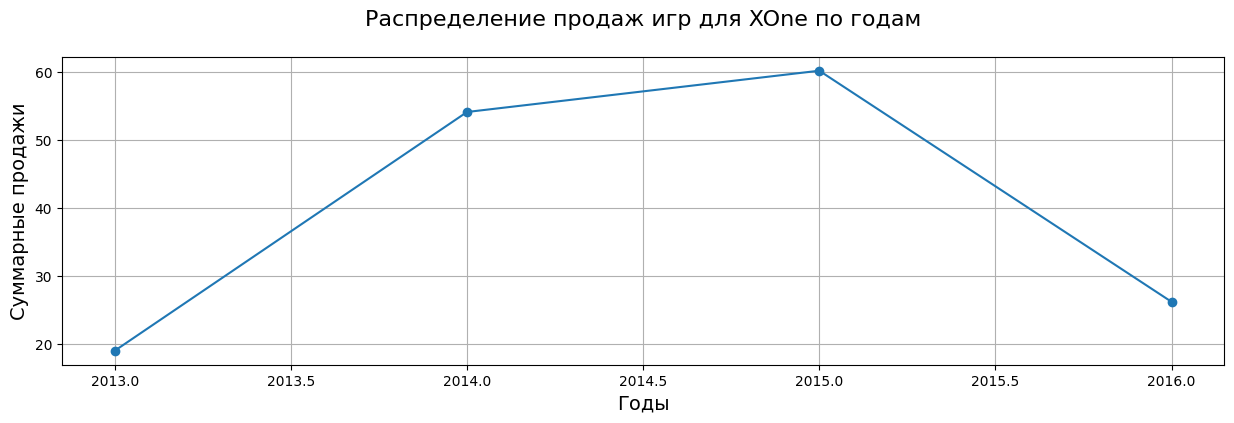

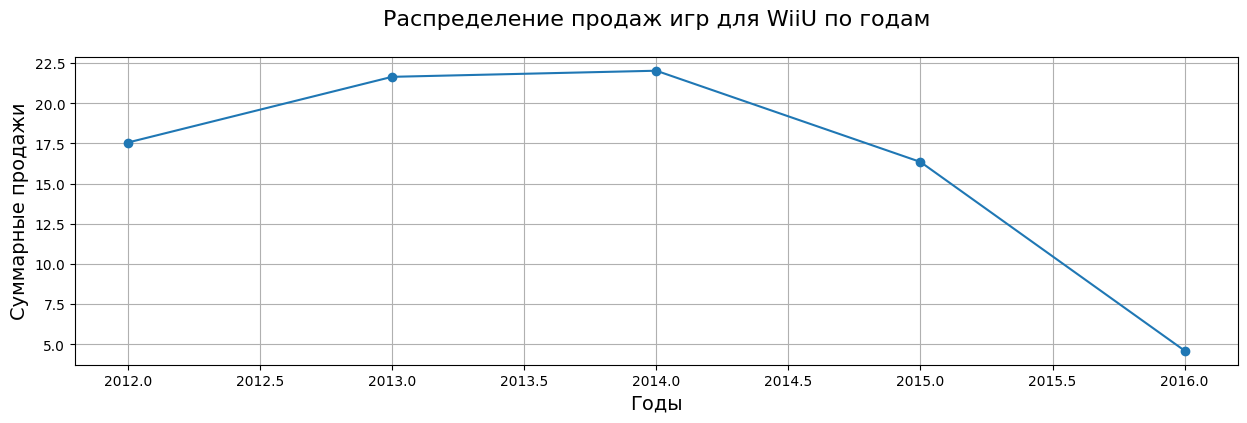

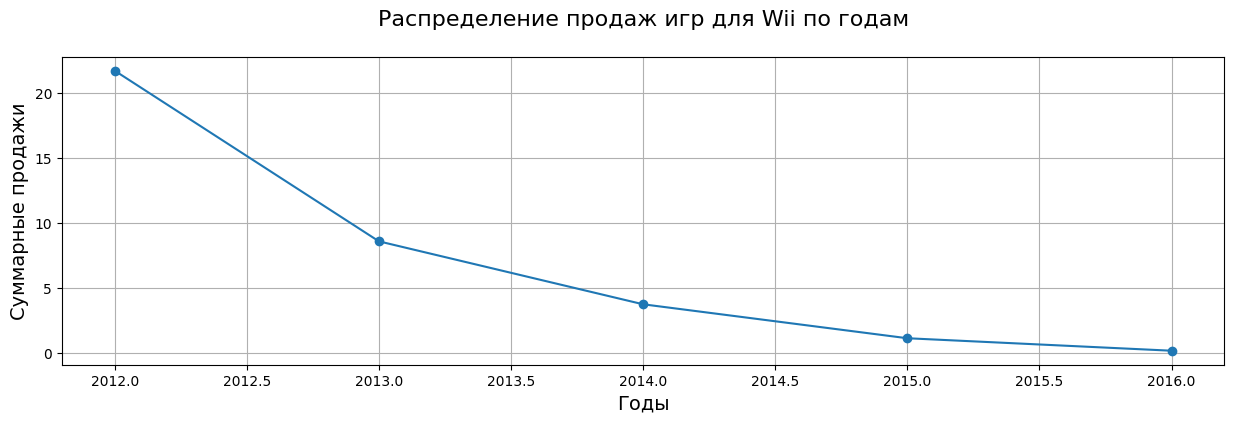

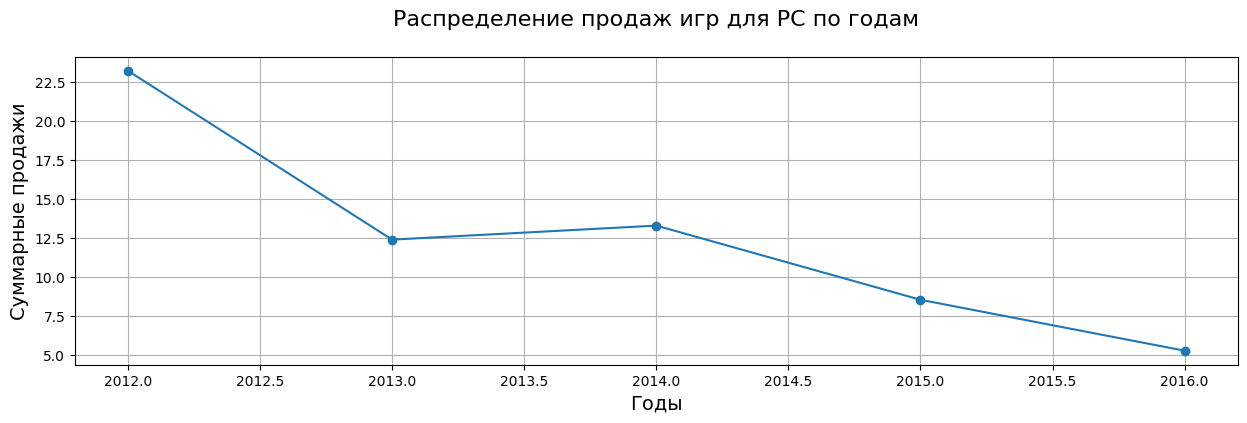

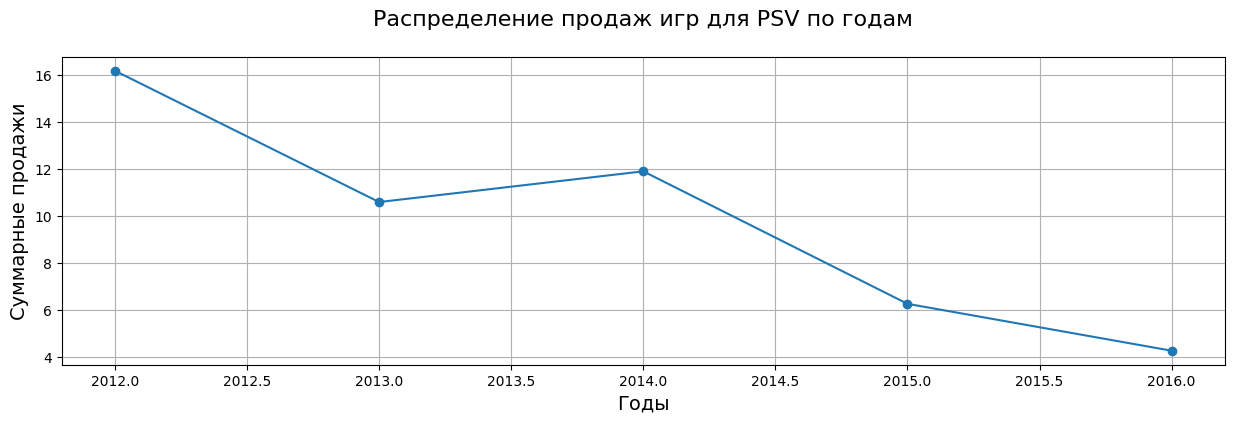

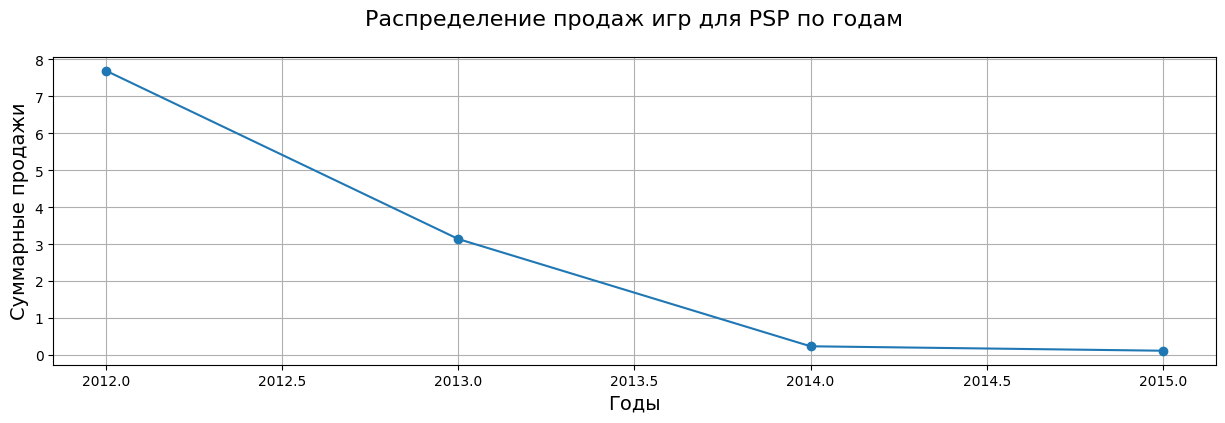

In [43]:
for platform in actual_df['platform'].unique():
    years_distribution(df=actual_df)

- **Росли продажи у PS4, 3DS, XOne, WiiU, PC и PSV.**
- **У остальных платформ продажи падают.**

Потенциально прибыльные платформы — PS4, 3DS и XOne.

### 4.3 Исследование потенциально прибыльных платформ
Построим диаграммы размаха по глобальным продажам в разбивке по потенциально прибыльным платформам.

In [44]:
def boxes(ylim=None):
    (
        actual_df
        .query('platform == "PS4" or platform == "3DS" or platform == "XOne"')
        .boxplot(column='total_sales', by='platform', figsize=(15, 6))
        .set_title('Диаграммы размаха по продажам в разбивке по платформам' + "\n\n", size=20)
    )
    plt.ylim(0, ylim)
    plt.xlabel('Платформы', size=16)
    plt.ylabel('Суммарные продажи', size=16)
    plt.show()

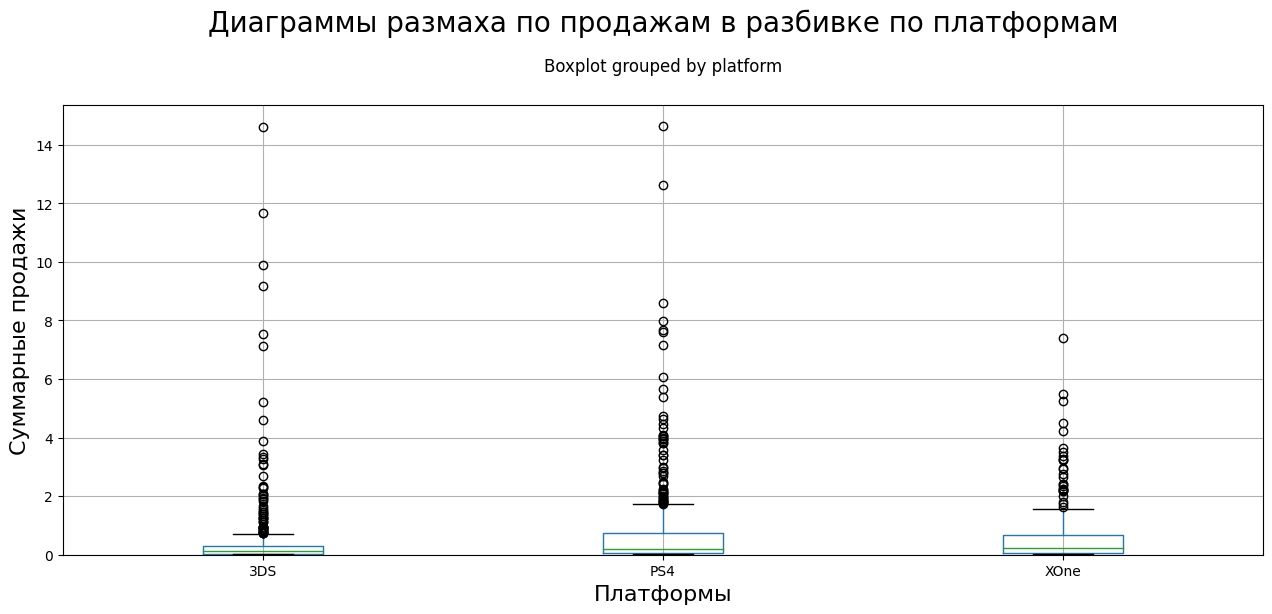

In [45]:
boxes()

Из-за выбросов сложно сравнивать квартили, поэтому построим дополнительный график, где будет отображена только нижняя часть "ящиков".

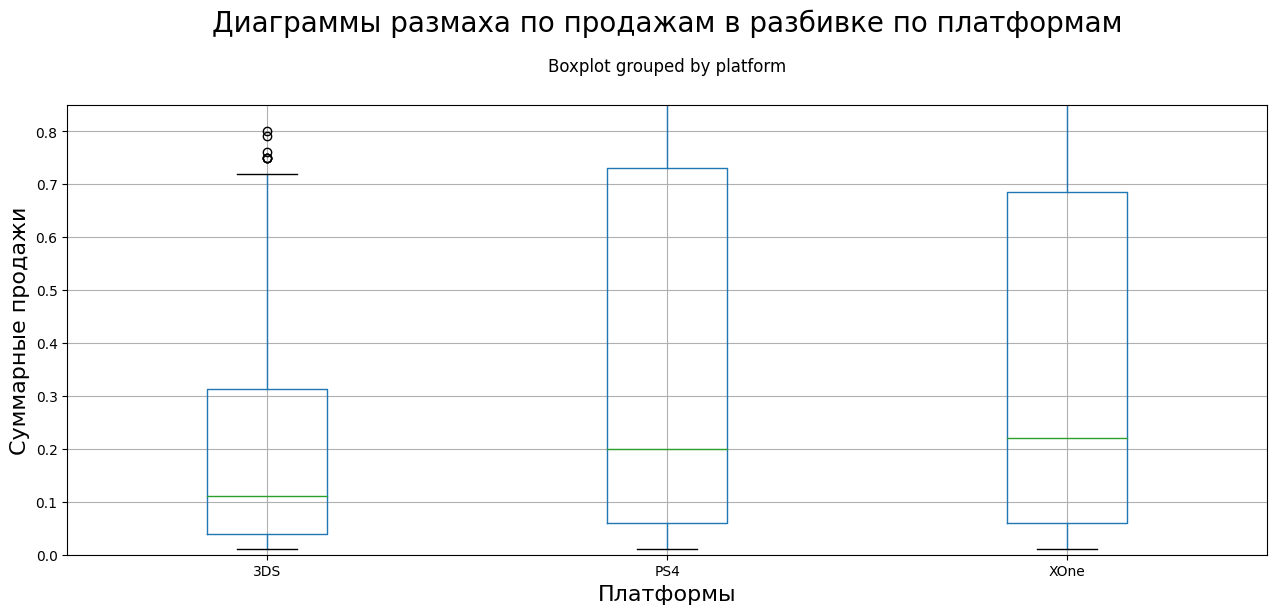

In [46]:
boxes(ylim=0.85)

Выведем статистические описание глобальных продаж в разбивке по потенциально прибыльным платформам.

In [47]:
for platform in ['3DS', 'PS4', 'XOne']:
    print('\n\033[1m Статистические описание глобальных продаж по ' + platform + '\033[0m\n', 
          actual_df.query('platform == @platform')['total_sales'].describe())


 Статистические описание глобальных продаж по 3DS
 count    396.000000
mean       0.491439
std        1.387161
min        0.010000
25%        0.040000
50%        0.110000
75%        0.312500
max       14.600000
Name: total_sales, dtype: float64

 Статистические описание глобальных продаж по PS4
 count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64

 Статистические описание глобальных продаж по XOne
 count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64


- **Все данные скошены вправо (расстояния между 25 квартилями и медианами меньше, чем расстояния между медианами и 75 квартилями).**
- **Нормальные значения у PS4 и XOne находятся в промежутке до 2 млн, у 3DS до 1.**
- **25 квартили у PS4 и XOne равны 60 тысячам, у 3DS 40.**
- **Медиана у XOne самая большая и равна 220 тысячам, у PS4 200, у 3DS 110.** 
- **75 квартиль у PS4 самый большой и равен 730 тысячам, у XOne 685, у 3DS 312.**
- **Максимальные значение у PS4 и 3DS находятся около 14,6 млн, у XOne около 7,4.**

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим матрицу диаграмм рассеяния и посчитаем корреляцию между отзывами и продажам.

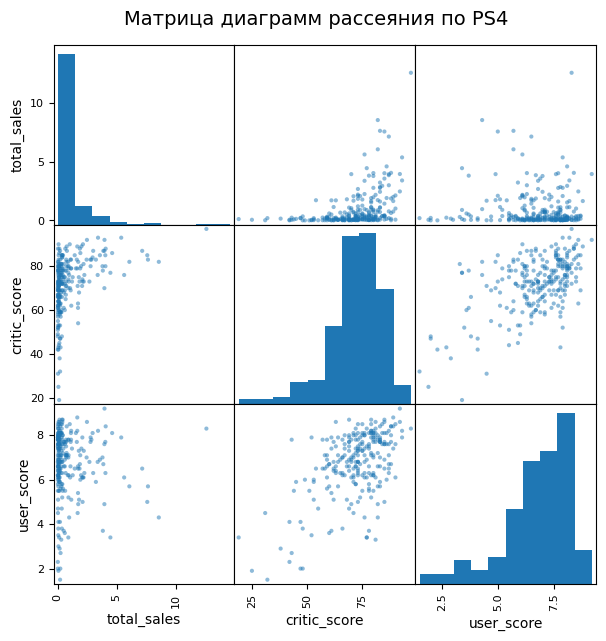

                Корреляция 


,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


In [48]:
def correlation(platform):
    df = actual_df.query('platform == @platform')[['total_sales', 'critic_score', 'user_score']]
    pd.plotting.scatter_matrix(df, figsize=(7, 7))
    plt.suptitle('Матрица диаграмм рассеяния по ' + platform, size=14, y=0.93)
    plt.show()
    print('\033[1m                Корреляция \033[0m')
    display(df.corr())

correlation(platform='PS4')

- **Оценки критиков демонстрируют прямую, средне-слабую корреляцию с "цифрами" продаж.**
- **Оценки пользователей корреляции с продажами не имеют.**
- **Оценки критиков демонстрируют прямую положительную, средне-слабую корреляцию с оценками пользователей.**

Соотнесём выводы с продажами игр на других платформах.

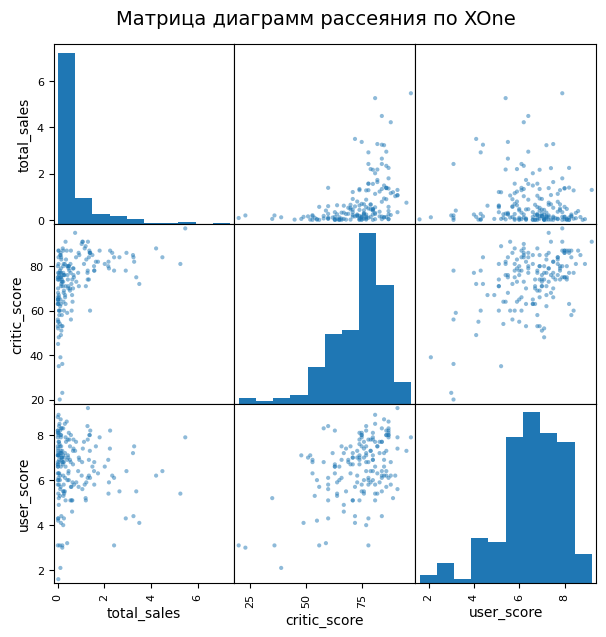

                Корреляция 


,total_sales,critic_score,user_score
total_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


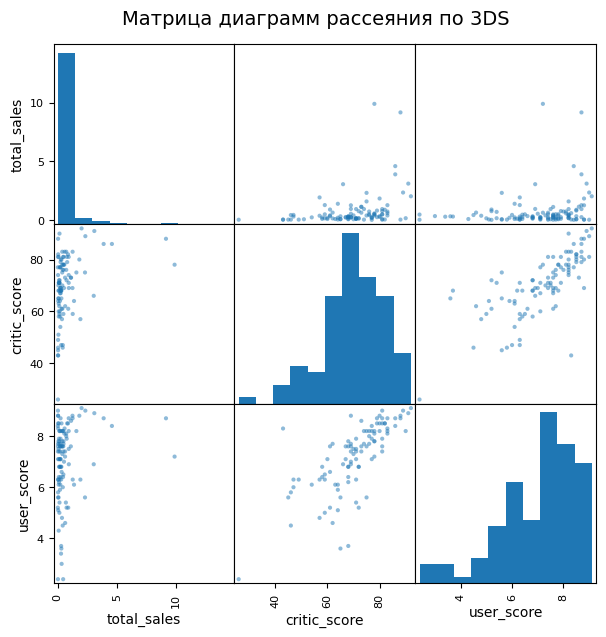

                Корреляция 


,total_sales,critic_score,user_score
total_sales,1.000000,0.320803,0.197583
critic_score,0.320803,1.000000,0.722762
user_score,0.197583,0.722762,1.000000


In [49]:
correlation(platform='XOne')
correlation(platform='3DS')

- **Корреляции PS4 и XOne очень схожи.**
- **У 3DS оценки критиков и пользователей демонстрируют прямые, слабые корреляции с "цифрами" продаж, при этом оценки критиков также демонстрируют прямую положительную, средне-слабую корреляцию с оценками пользователей.**

### 4.4 Исследование жанров
Посмотрим на общее распределение игр по жанрам.

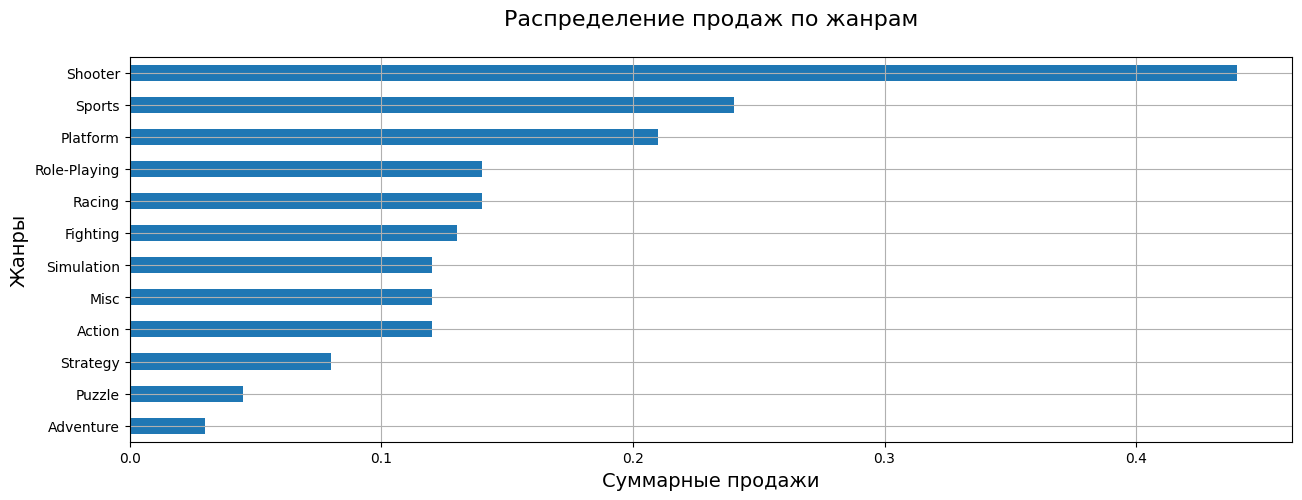

In [50]:
(
    actual_df
    .pivot_table(index='genre', values='total_sales', aggfunc='median')
    .sort_values(by='total_sales')
    .plot(grid=True, figsize=(15, 5), legend=False, kind='barh')
)
plt.title('Распределение продаж по жанрам' + "\n", size=16)
plt.xlabel('Суммарные продажи', size=14)
plt.ylabel('Жанры', size=14)
plt.show()

- **Самые прибыльные жанры — Shooter, Sports, Platform, Role-Playing и Racing. Я думаю, их популярность обусловлена динамичностью и возможностью соревнований между игроками.**
- **Самые неприбыльные — Misc, Action, Strategy, Puzzle и Adventure. Скорее всего эти жанры приносят слишком мало острых эмоций игрокам, поэтому они и не популярны.**

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>Результаты исследовательского анализа:</b>
        <li>Примерный срок, за который появляются новые и исчезают старые платформы — 10 лет.</li>
        <li>Потенциально прибыльные платформы — PS4, 3DS и XOne.</li>
        <li>Все данные по продажам скошены вправо. </li>
        <li>Нормальные значения у PS4 и XOne находятся в промежутке до 2 млн, у 3DS до 1.</li> 
        <li>25 квартили у PS4 и XOne равны 60 тысячам, у 3DS 40.</li>
        <li>Медиана у XOne самая большая и равна 220 тысячам, у PS4 200, у 3DS 110.</li>
        <li>75 квартиль у PS4 самый большой и равен 730 тысячам, у XOne 685, у 3DS 312.</li>
        <li>Максимальные значение у PS4 и 3DS находятся около 14,6 млн, у XOne около 7,4.</li>
        <li>У PS4 оценки критиков демонстрируют прямую, средне-слабую корреляцию с "цифрами" продаж. Оценки пользователей корреляции с продажами не имеют. </li>
        <li>Корреляции PS4 и XOne очень схожи. </li>
        <li>У 3DS оценки критиков и пользователей демонстрируют прямые, слабые корреляции с "цифрами" продаж. </li>
        <li>У всех платформ оценки критиков демонстрируют прямую положительную, средне-слабую корреляцию с оценками пользователей.</li>
        <li>Самые прибыльные жанры — Shooter, Sports, Platform, Role-Playing и Racing. Самые неприбыльные — Misc, Action, Strategy, Puzzle и Adventure.</li>
    </p>
            
    
</div>

## 5 Составление портрета пользователя каждого региона
### 5.1 Определение самых популярных платформ
Выведем распределения продаж по платформам в регионах и их доли.

In [51]:
def plot(region_distribution, total_distribution, country, title='платформ', ylabel='Платформы'):
    (
        (region_distribution / total_distribution)
        .sort_values()
        .plot(kind='barh', legend=False, figsize=(15, 5), grid=True)
        .set_title('Доли продаж ' + title + ' в ' + country + "\n", size=16)
    )
    plt.xlabel('Доли', size=14)
    plt.ylabel(ylabel, size=14)
    plt.show()

region_codes = ['na', 'eu', 'jp']
countries = ['Северной Америке ', 'Европе ', 'Японии ']

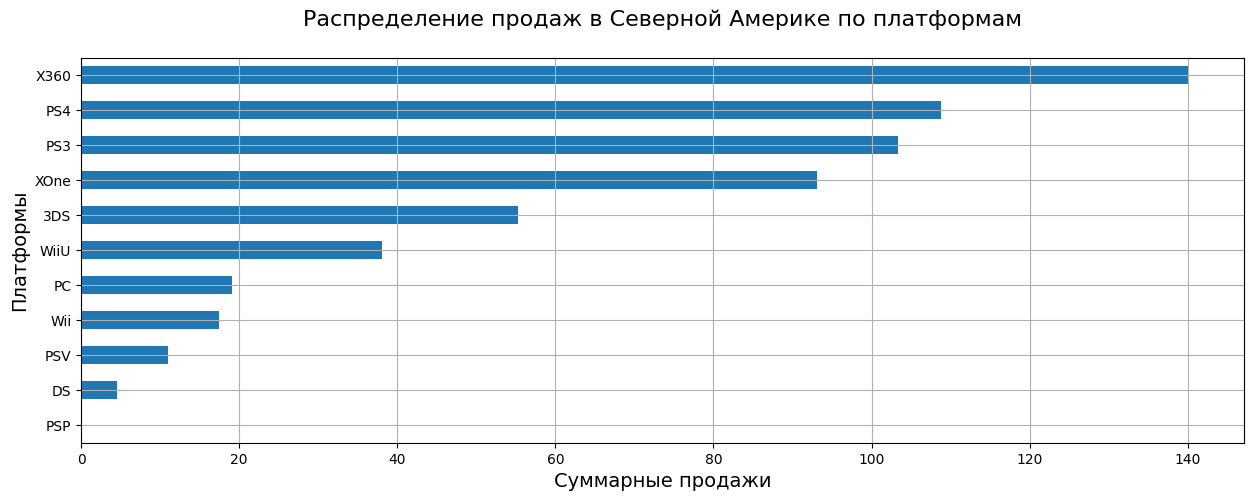

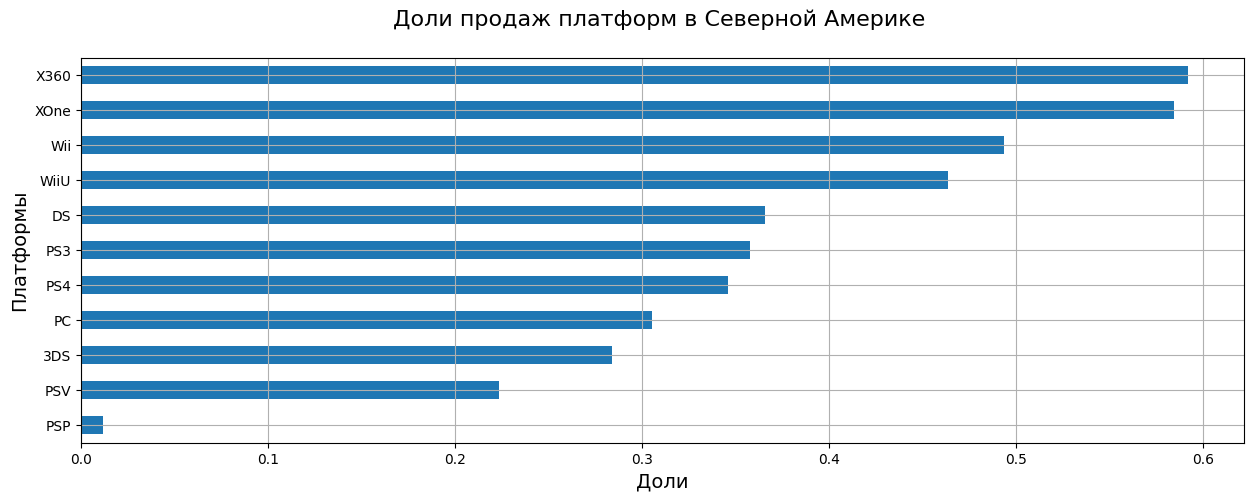

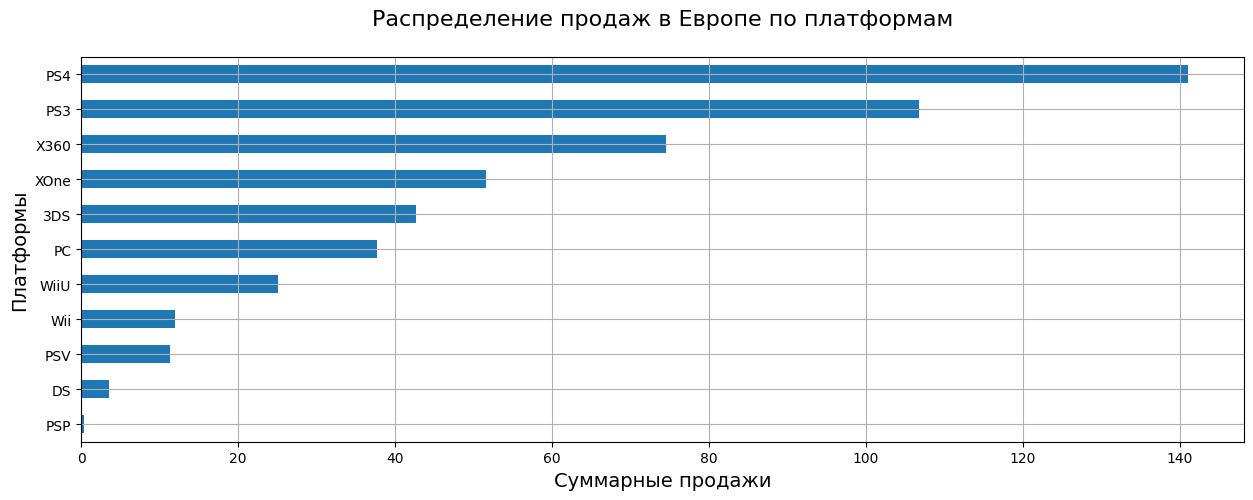

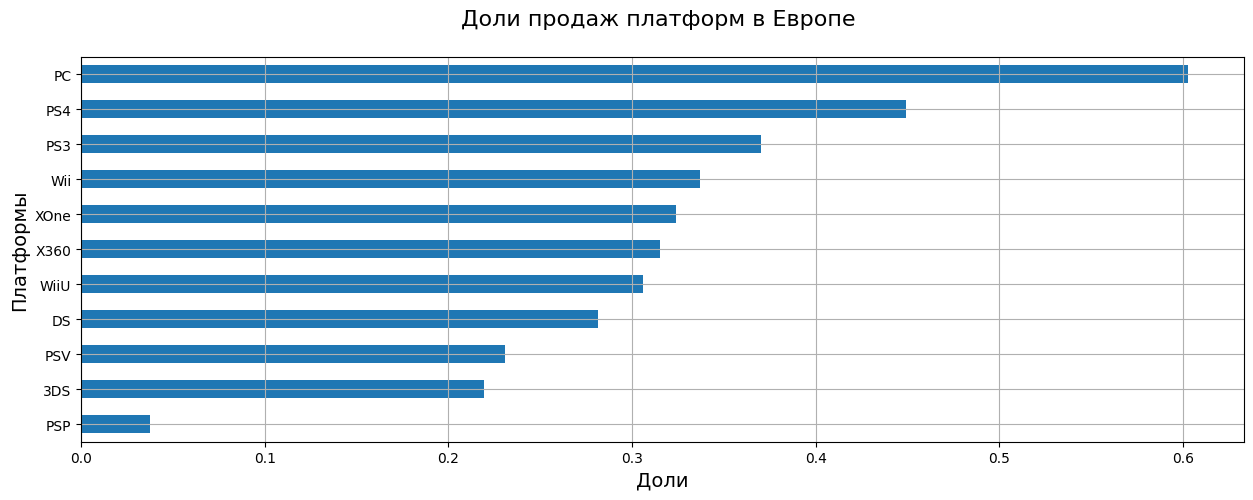

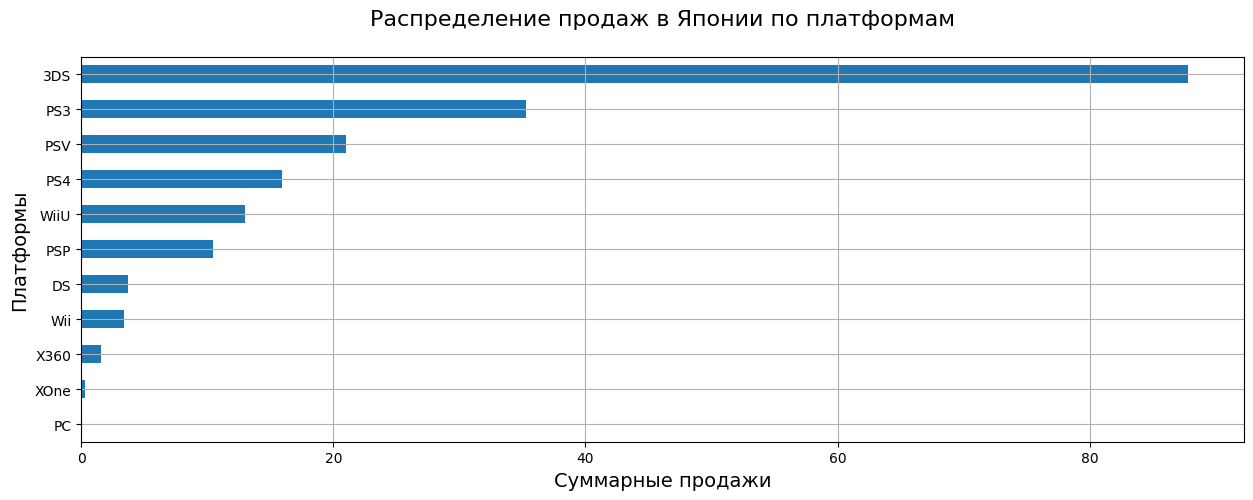

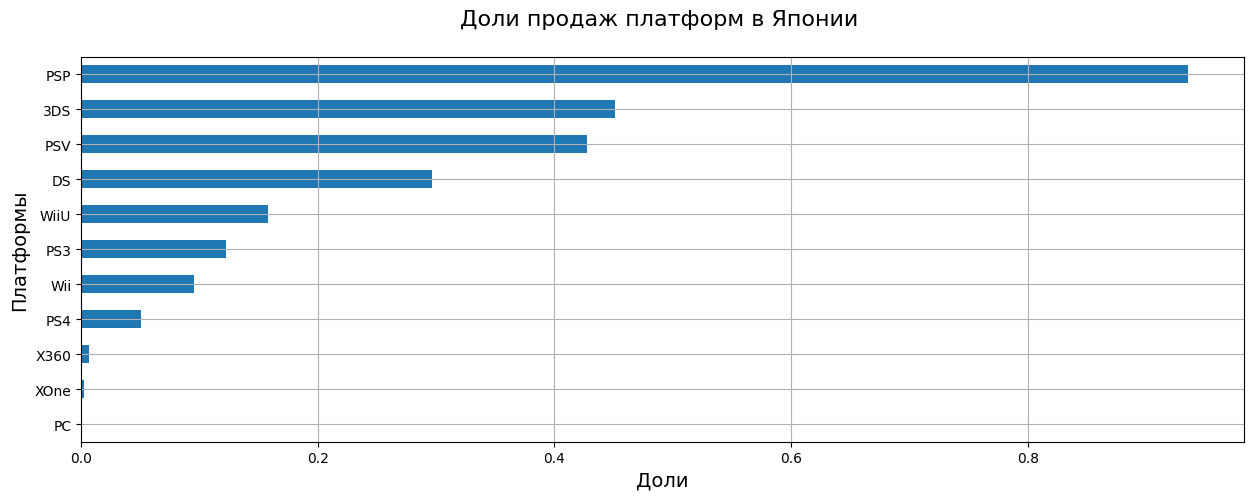

In [52]:
for region_code, country in zip(region_codes, countries):
    region_distribution = categorical_distribution(df=actual_df, values=region_code, country=' в ' + country)
    plot(region_distribution, platform_distribution, country)

Северная Америка
- **Самые популярные платформы — X360, PS4, PS3, XOne и 3DS.**
- **Самая большая доля продаж у X360.**
- **Самая малая доля продаж у PSP.**

Европа
- **Самые популярные платформы — PS4, PS3, X360, XOne и 3DS.**
- **Самая большая доля продаж у PC.**
- **Самая малая доля продаж у PSP.**

Япония
- **Самые популярные платформы — 3DS, PS3, PSV, PS4 и WiiU.**
- **Самая большая доля продаж у PSP.**
- **Самая малая доля продаж у PC.**

### 5.2 Определение самых популярных жанров
Выведем распределение продаж по жанрам в регионах и их доли.

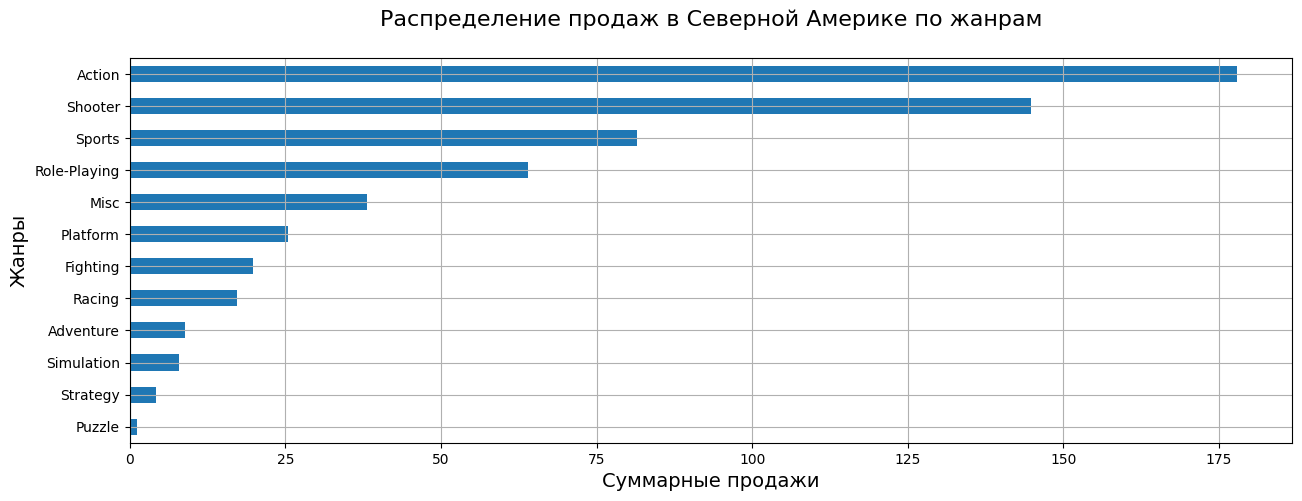

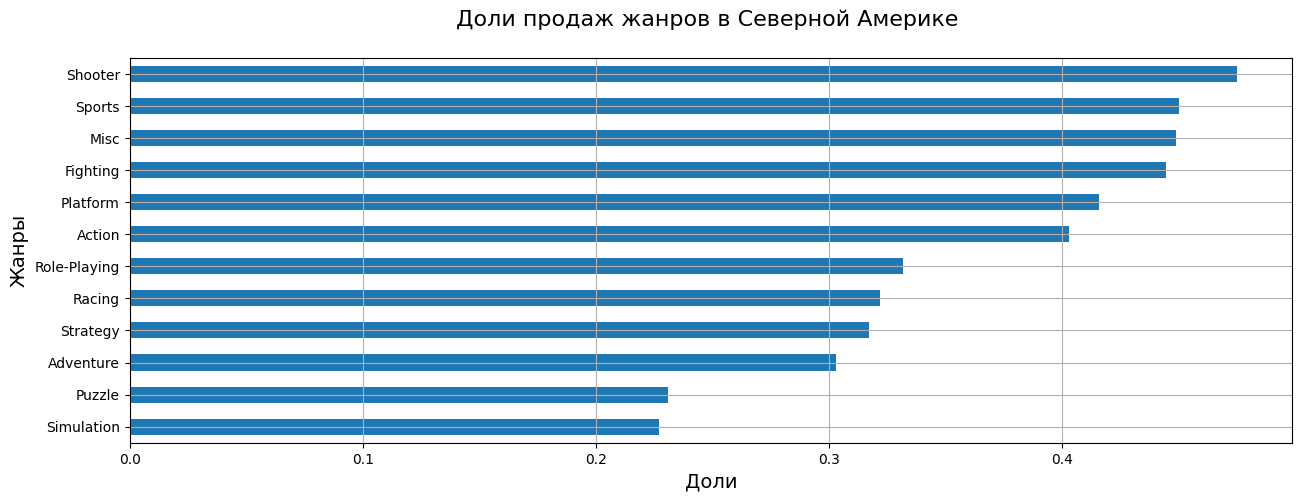

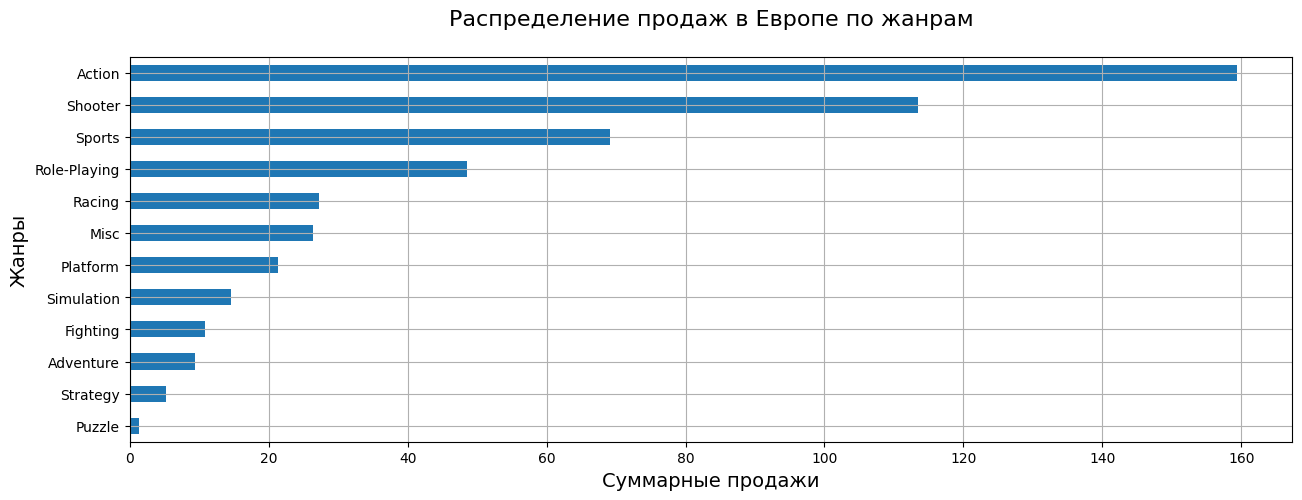

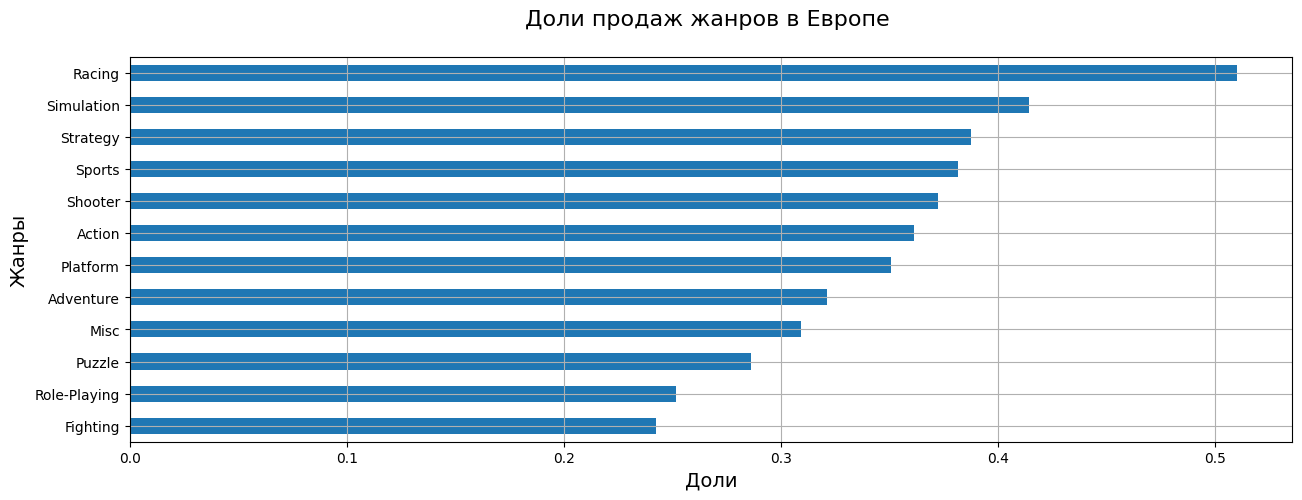

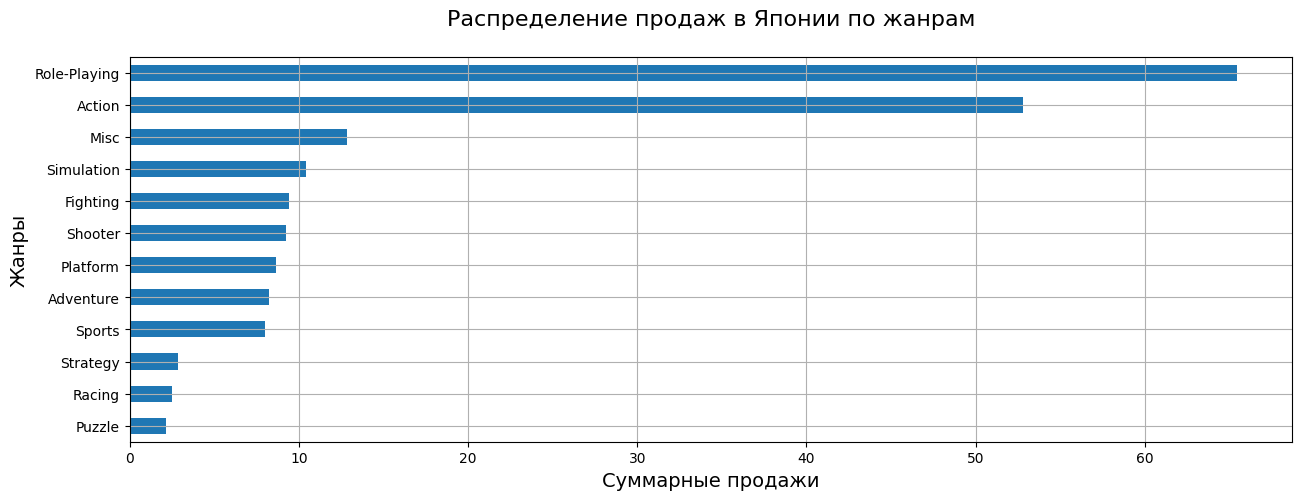

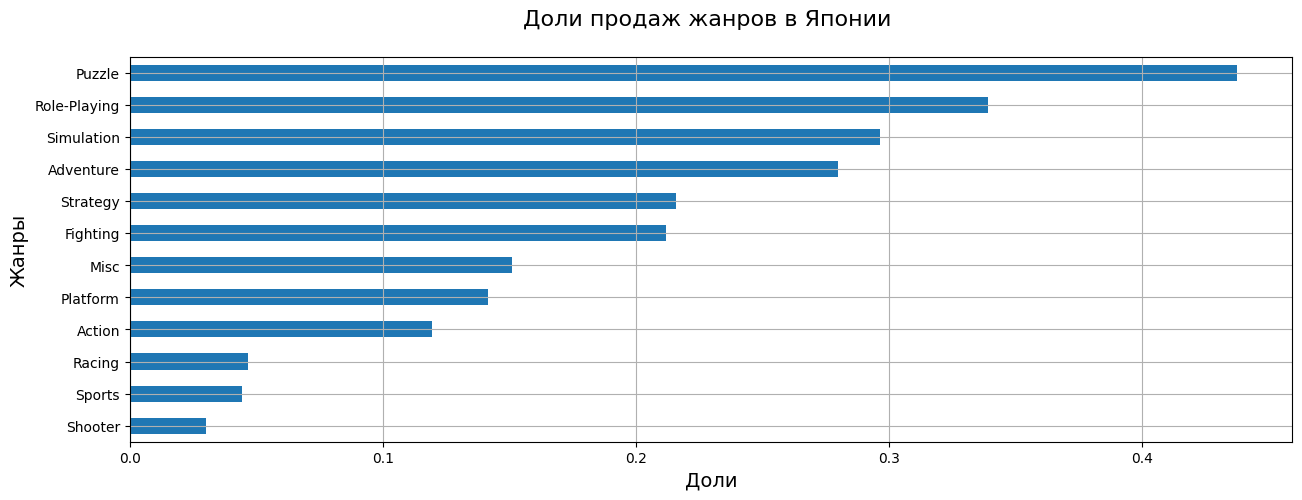

In [53]:
genre_distribution = actual_df.groupby('genre')['total_sales'].sum().sort_values()

for value, country in zip(region_codes, countries):
    region_distribution = categorical_distribution(df=actual_df, index='genre', values=value, 
                 country=' в ' + country, title='жанрам', ylabel='Жанры')
    plot(region_distribution, genre_distribution, country, title='жанров', ylabel='Жанры')

Северная Америка
- **Самые популярные жанры — Action, Shooter, Sports, Role-Playing и Misc.**
- **Самая большая доля продаж у Shooter.**
- **Самая малая доля продаж у Simulation.**

Европа
- **Самые популярные жанры — Action, Shooter, Sports, Role-Playing и Racing.**
- **Самая большая доля продаж у Racing.**
- **Самая малая доля продаж у Fighting.**

Япония
- **Самые популярные жанры — Role-Playing, Action, Misc, Simulation и Fighting.**
- **Самая большая доля продаж у Puzzle.**
- **Самая малая доля продаж у Shooter.**

### 5.3 Определение влияния рейтинга ESRB на продажи
Выведем общее распределение продаж по рейтингам.

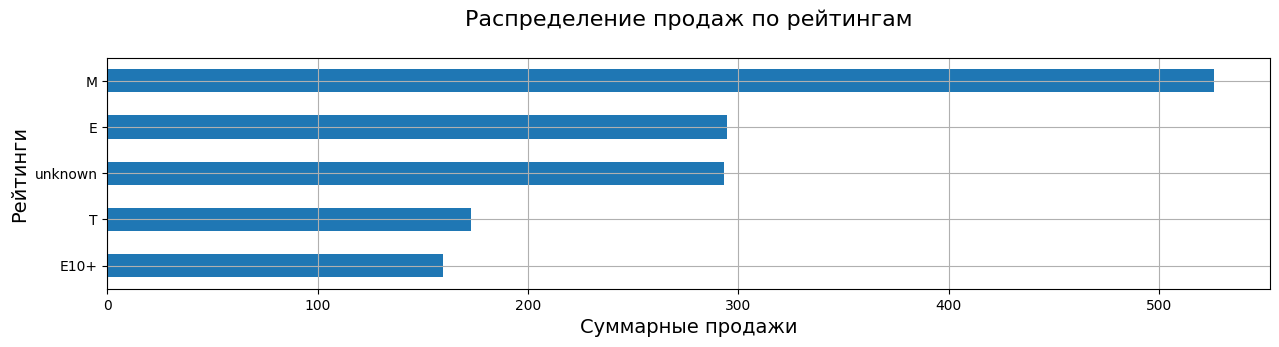

In [54]:
rating_distribution = categorical_distribution(df=actual_df, index='rating', title='рейтингам', 
                                               ylabel='Рейтинги', figsize=3)

Выведем распределение продаж по рейтингам в регионах.

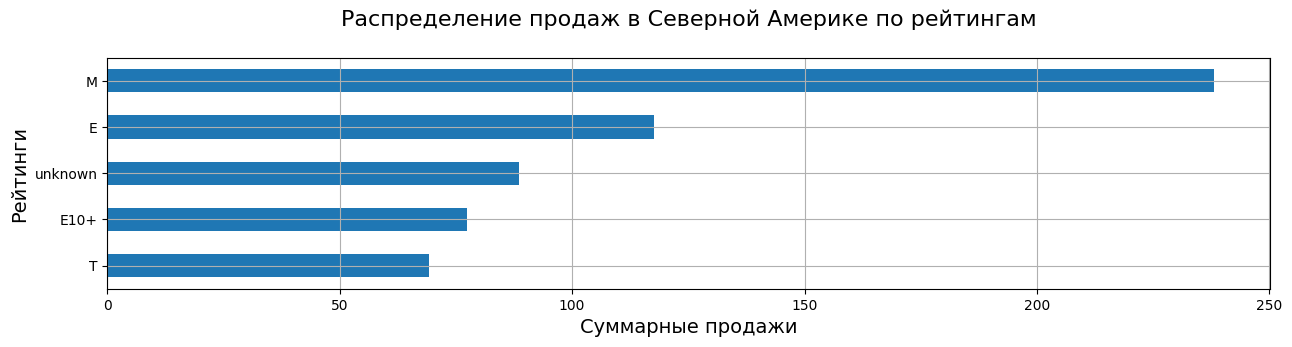

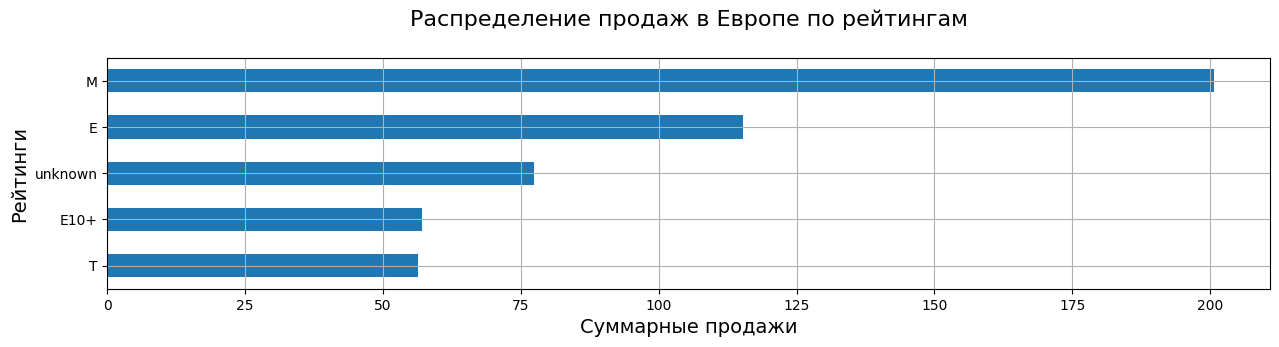

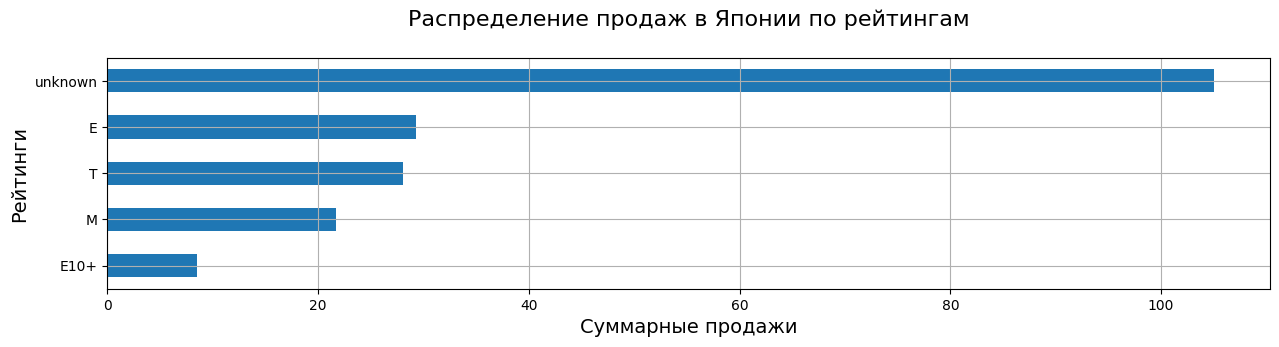

In [55]:
for value, country in zip(region_codes, countries):
    region_distribution = categorical_distribution(df=actual_df, index='rating', values=value, 
                                                   country=' в ' + country, title='рейтингам', ylabel='Рейтинги', figsize=3)

- **Самый популярный рейтинг в Северной Америке и Европе — M (материалы игры не подходят для лиц младше 17 лет).**
- **В Японии самыми популярными являются игры без рейтинга ESRB. Это можно объяснить наличием в Японии собственной рейтинговой организации — CERO ([статья "Как получить возрастной рейтинг в Японии"](https://dtf.ru/gamedev/122994-kak-poluchit-vozrastnoy-reyting-v-yaponii-opyt-izdatelya-nekki)).**

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>Портреты пользователей таковы:</b>
        <li>В Северной Америке самые популярные платформы — X360, PS4, PS3, XOne и 3DS. Самые популярные жанры — Action, Shooter, Sports, Role-Playing и Misc. Самый популярный рейтинг — M.</li>
        <li>В Европе самые популярные платформы — PS4, PS3, X360, XOne и 3DS. Самые популярные жанры — Action, Shooter, Sports, Role-Playing и Racing. Самый популярный рейтинг — M.</li>
        <li>В Японии самые популярные платформы — 3DS, PS3, PSV, PS4 и WiiU. Самые популярные жанры — Role-Playing, Action, Misc, Simulation и Fighting. Самыми популярными являются игры без рейтинга ESRB.</li>
    </p>
            
    
</div>

## 6 Проверка гипотез
### 6.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
```
H_0: Средние пользовательские рейтинги платформы "Xbox One" = средние пользовательские рейтинги платформы "PC"`
H_a: Средние пользовательские рейтинги платформы "Xbox One" ≠ средние пользовательские рейтинги платформы "PC"`
```
Так как надо проверить гипотезу о равенстве среднего двух генеральных совокупностей, будем использовать метод `scipy.stats.ttest_ind()`.

In [56]:
results = st.ttest_ind(
    actual_df[(actual_df['platform'] =='XOne') & (actual_df['user_score'].notnull())]['user_score'], 
    actual_df[(actual_df['platform'] =='PC') & (actual_df['user_score'].notnull())]['user_score'], equal_var=False)

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


### 6.2 Средние пользовательские рейтинги жанров Action и Sports разные
```
H_0: Средние пользовательские рейтинги жанра "Action" = средние пользовательские рейтинги жанра "Sports"`
H_a: Средние пользовательские рейтинги жанра "Action" ≠ средние пользовательские рейтинги жанра "Sports"`
```
Так как надо проверить гипотезу о равенстве среднего двух генеральных совокупностей, будем использовать метод `scipy.stats.ttest_ind()`.

In [57]:
results = st.ttest_ind(
    actual_df[(actual_df['genre'] =='Action') & (actual_df['user_score'].notnull())]['user_score'], 
    actual_df[(actual_df['genre'] =='Sports') & (actual_df['user_score'].notnull())]['user_score'], equal_var=False)

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

5.989458066467418e-20
Отвергаем нулевую гипотезу


<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>После проверки гипотез выяснилось, что мы не можем опровергнуть то, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, и то, что средние пользовательские рейтинги жанров Action и Sports разные.</b>
    </p>
            
    
</div>

## 7 Общий вывод

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Проделано:</b>
        <ol><li>Изучена общая информацию о данных.</li>
        <li>Проведена предподготовка данных: исправлены названия столбцов, удалены пропуски, изменены типы данных, обработаны дубликаты.</li>
        <li>Проведён исследовательский анализ данных.</li>
        <li>Составлен портрет пользователя каждого региона.</li>
        <li>Проверены гипотезы.</li>
        </ol>
        <b>Выявлено:</b>
        <li>Примерный срок, за который появляются новые и исчезают старые платформы — 10 лет;</li>
        <li>Потенциально прибыльные платформы — PS4, 3DS и XOne;</li>
        <li>Все данные по продажам скошены вправо. </li>
        <li>Нормальные значения у PS4 и XOne находятся в промежутке до 2 млн, у 3DS до 1.</li> 
        <li>25 квартили у PS4 и XOne равны 60 тысячам, у 3DS 40.</li>
        <li>Медиана у XOne самая большая и равна 220 тысячам, у PS4 200, у 3DS 110.</li>
        <li>75 квартиль у PS4 самый большой и равен 730 тысячам, у XOne 685, у 3DS 312.</li>
        <li>Максимальные значение у PS4 и 3DS находятся около 14,6 млн, у XOne около 7,4.</li>
        <li>У PS4 и XOne оценки критиков демонстрируют прямую, средне-слабую корреляцию с "цифрами" продаж. Оценки пользователей корреляции с продажами не имеют. </li>
        <li>У 3DS оценки критиков и пользователей демонстрируют прямые, слабые корреляции с "цифрами" продаж. </li>
        <li>У всех платформ оценки критиков демонстрируют прямую положительную, средне-слабую корреляцию с оценками пользователей.</li>
        <li>Самые прибыльные жанры — Shooter, Sports, Platform, Role-Playing и Racing. Самые неприбыльные — Misc, Action, Strategy, Puzzle и Adventure.</li>
        <li>В Северной Америке самые популярные платформы — X360, PS4, PS3, XOne и 3DS. Самые популярные жанры — Action, Shooter, Sports, Role-Playing и Misc. Самый популярный рейтинг — M.</li>
        <li>В Европе самые популярные платформы — PS4, PS3, X360, XOne и 3DS. Самые популярные жанры — Action, Shooter, Sports, Role-Playing и Racing. Самый популярный рейтинг — M.</li>
        <li>В Японии самые популярные платформы — 3DS, PS3, PSV, PS4 и WiiU. Самые популярные жанры — Role-Playing, Action, Misc, Simulation и Fighting. Самыми популярными являются игры без рейтинга ESRB.</li>
        <li>Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, не может быть отвергнута.</li>
        <li>Гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные, не может быть отвергнута.</li><br>
        <b>Рекомендации:</b>
    <li>Сфокусировать внимание стоит на таких платформах как PS4, 3DS и XOne, они являются самыми прибыльными и популярными.</li>
    <li>Что касается жанров, самые прибыльные и популярные — Shooter и Sports, также, в популярных — Action.</li>
    <li>В рейтингах же лидирует M (материалы игры не подходят для лиц младше 17 лет).</li>
   </p>  
</div>